In [1]:
import rarfile
import numpy as np
inf=float("inf")

import random
from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import umap
import pickle

import os
import stablerank.srank as sr

from dtw import *

import fMRIanalysis.data as data
import fMRIanalysis.plotting as plotting

import time

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
med_info = pd.read_excel(r'data/Medicineinfo.xlsx').iloc[:,1].to_numpy()
med_indices = np.where(med_info == 1)[0]

range_of_subjects = range(1, 107)

colors = dict()
labels = dict()
for subject in range_of_subjects:
    if subject < 16:
        label = "CTR"
        color = 'k'
    elif (subject >= 16 and subject < 88):
        if subject in med_indices:
            label = "PD_CN_med"
            color = 'b'
        else:
            label = "PD_CN_nonMed"
            color = 'g'
    else:
        if subject in med_indices:
            label = "PD_MCI_med"
            color = 'y'
        else:
            label = "PD_MCI_nonMed"
            color = 'r'
    labels[subject] = label
    colors[subject] = color

# Analyzing best settings for filtered delayedPearson (delay1)

## Transpose multiplication, H0

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.89s/it]


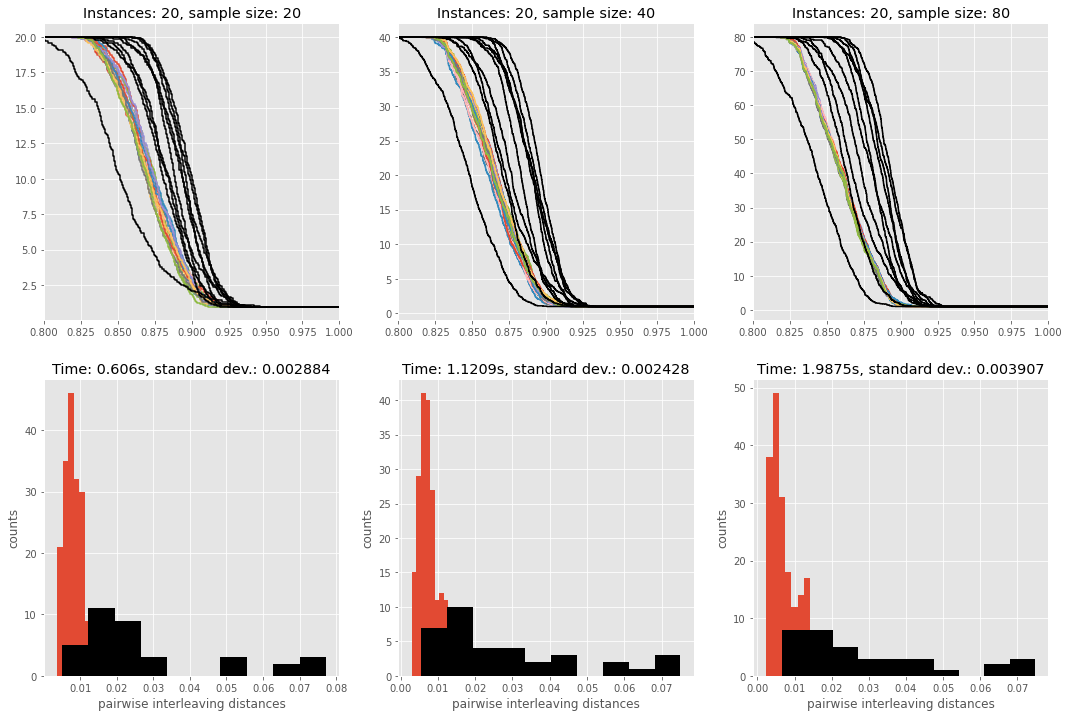

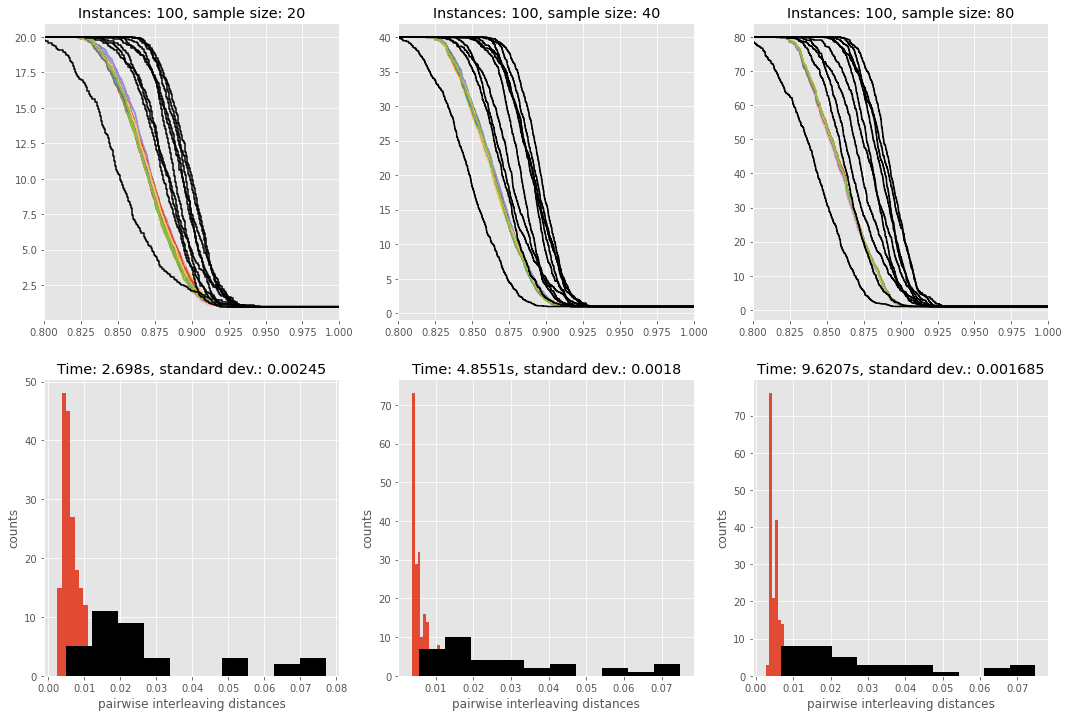

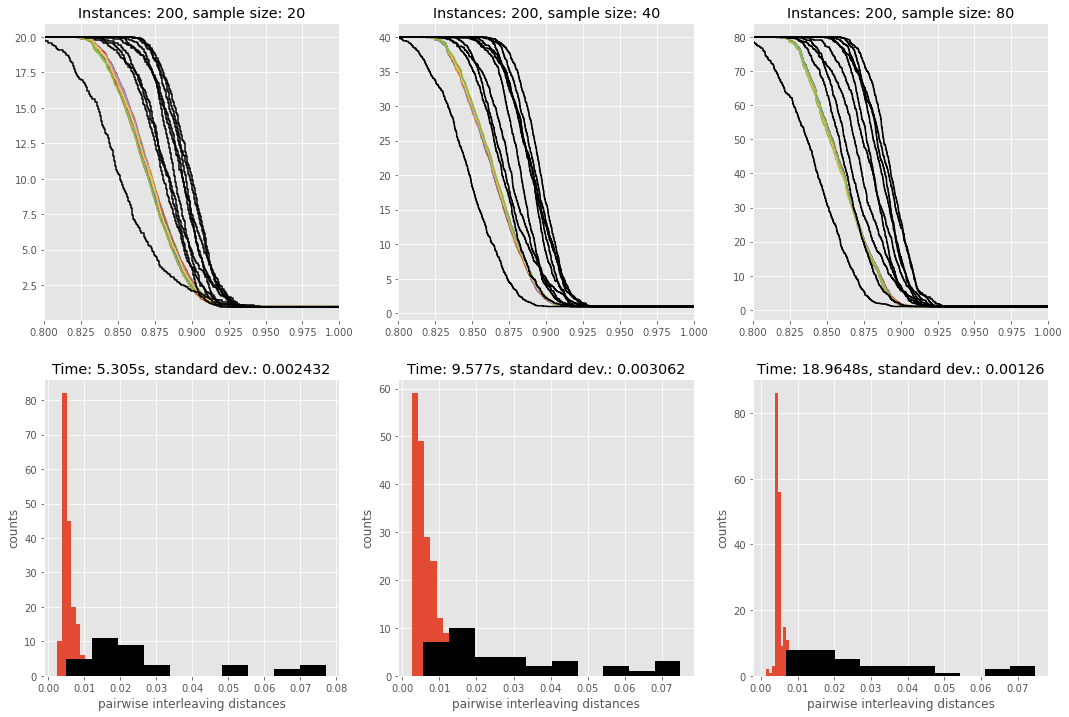

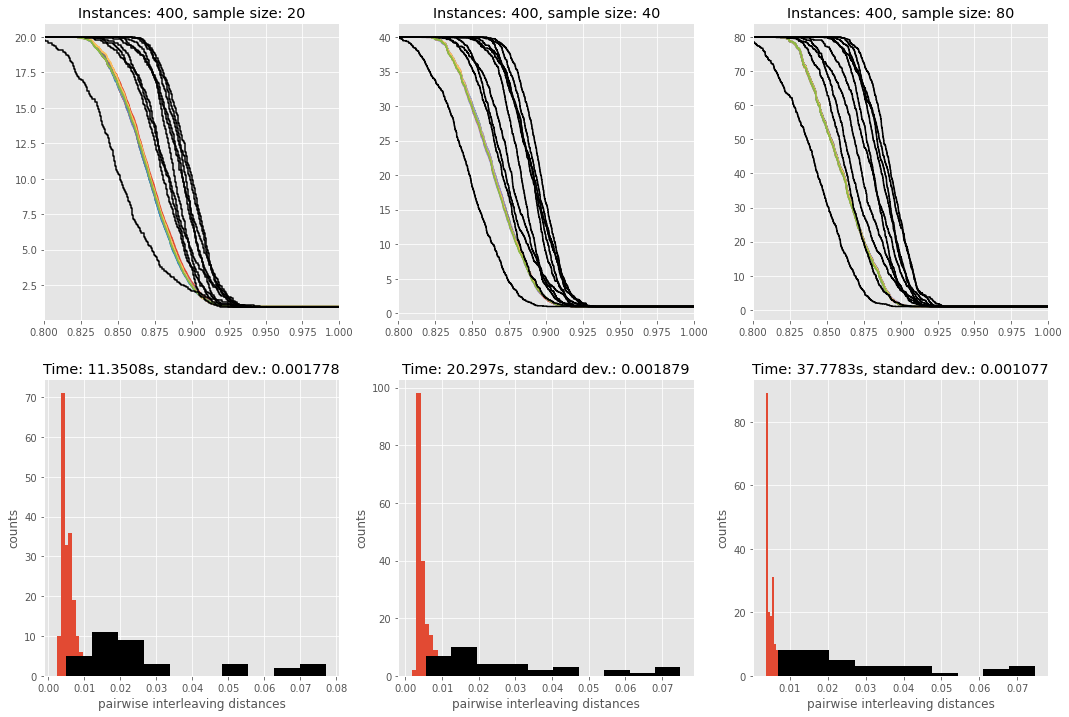

In [17]:
n = 20
sample_sizes = [20, 40, 80] #[4, 8]
numbers_instances = [20, 100, 200, 400] #[5, 10, 2]
#sample_sizes = [4, 8]
#numbers_instances = [2, 5, 10]

hsr_subjects = dict()
range_of_subjects = range(2, 12)

for k in range(len(sample_sizes)):
    sample_size = sample_sizes[k]
    sample = sr.get_sample(number_instances = 20, sample_size = sample_size, probabilities = 200)
    
    hsr_subjects[sample_size] = dict()
    
    for subject in tqdm(range_of_subjects):
        dist_mat = data.DistanceMatrix(subject = subject, 
                                       method = "filtered_delayedPearson\\FDP_delay1", 
                                       symmetrization = "transpose_multiplication").dist_mat
        d = sr.Distance(dist_mat)
        barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
        hsr_subjects[sample_size][subject] = sr.bc_to_sr(barcode, degree = "H0")
    
dist_mat = data.DistanceMatrix(subject = 1, 
                               method = "filtered_delayedPearson\\FDP_delay1", 
                               symmetrization = "transpose_multiplication").dist_mat
d = sr.Distance(dist_mat)

execution_times = []
stds = []

for j in range(len(numbers_instances)):
    number_instances = numbers_instances[j]
    
    fig, ax = plt.subplots(2, len(sample_sizes), figsize=(len(sample_sizes)*6, 2*6))
    
    for k in range(len(sample_sizes)):
        sample_size = sample_sizes[k]
        
        hsr = dict()
        
        start = time.time()
        for i in tqdm(range(n)):
            sample = sr.get_sample(number_instances, sample_size, 200)
            barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
            hsr[i] = sr.bc_to_sr(barcode, degree = "H0")
            hsr[i].plot(ax = ax[0, k])
        end = time.time()
        for subject in range_of_subjects:
            hsr_subjects[sample_size][subject].plot(ax = ax[0, k], color = 'k')
            
        interleaving_dists = []
        interleaving_dists_subjects = []
        
        for i in range(n):
            for j in range(i+1, n):
                interleaving_dists.append(hsr[i].interleaving_distance(hsr[j]))
        for i in range_of_subjects:
            for j in range(i+1, range_of_subjects[-1]):
                interleaving_dists_subjects.append(hsr_subjects[sample_size][i].interleaving_distance(hsr_subjects[sample_size][j]))
        
        std = np.std(np.array(interleaving_dists))
        stds.append(std)
        
        ax[0, k].set_xlim(0.8, 1.0)
        ax[0, k].set_title("Instances: "+str(number_instances)+", sample size: "+str(round(sample_size, 4)))
        
        ax[1, k].hist(interleaving_dists, bins = 10)
        ax[1, k].hist(interleaving_dists_subjects, color = 'k', bins = 10)
        ax[1, k].set_title("Time: "+str(round(end-start, 4))+"s, standard dev.: "+str(round(std,6)))
        ax[1, k].set_xlabel("pairwise interleaving distances")
        ax[1, k].set_ylabel("counts")
        
        execution_times.append(end-start)

## Transpose multiplication, H1

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]


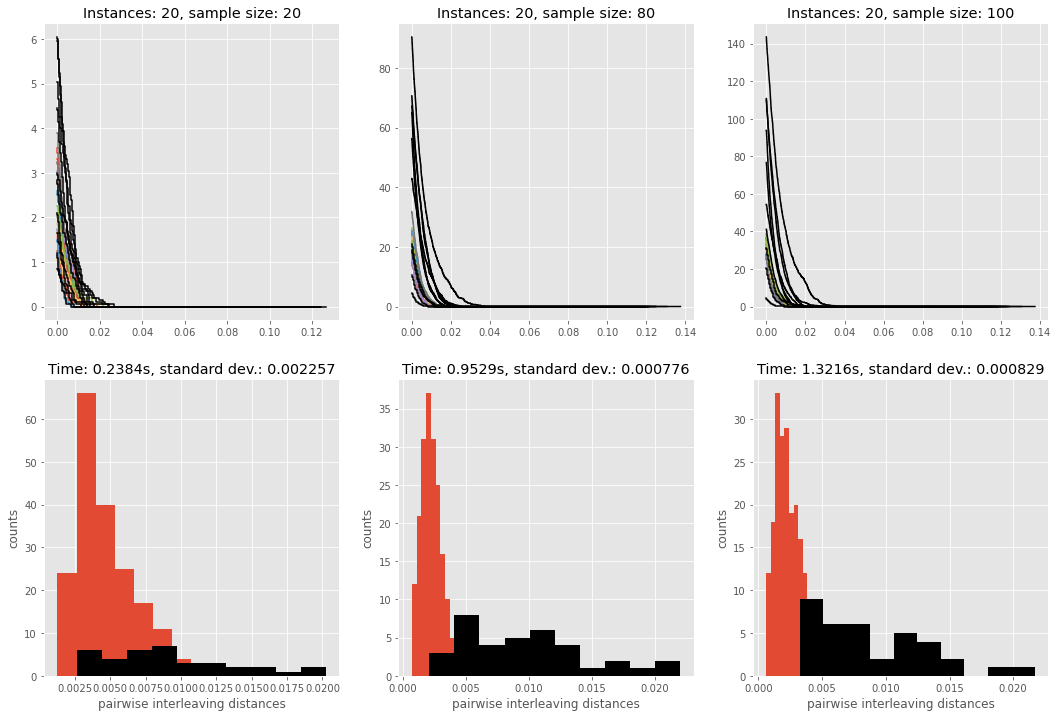

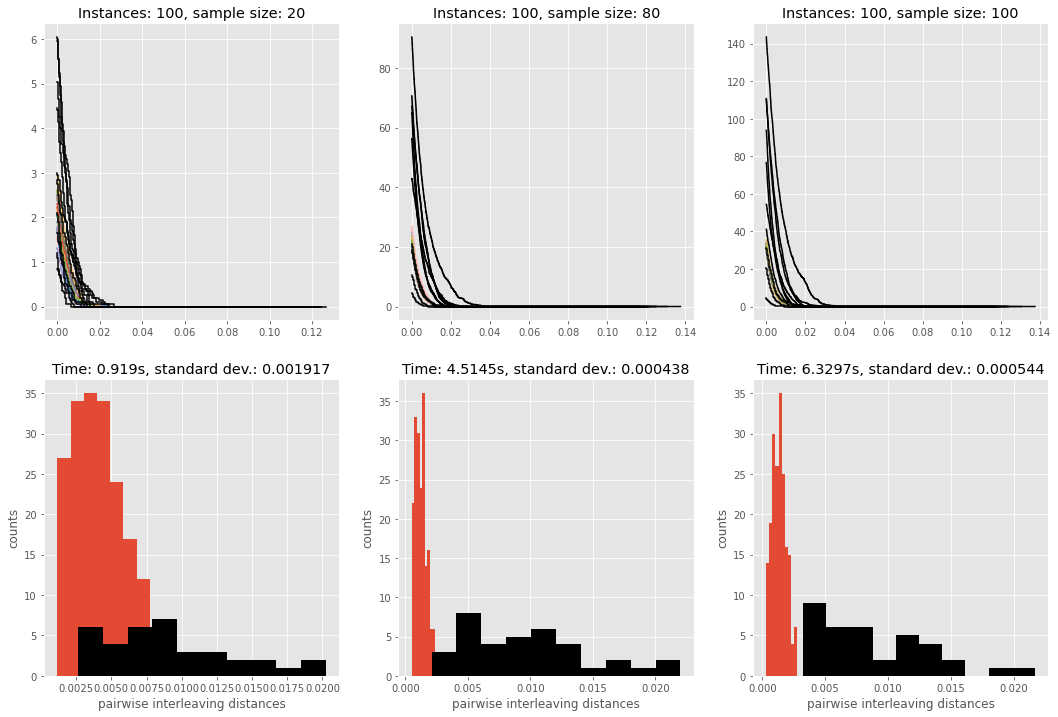

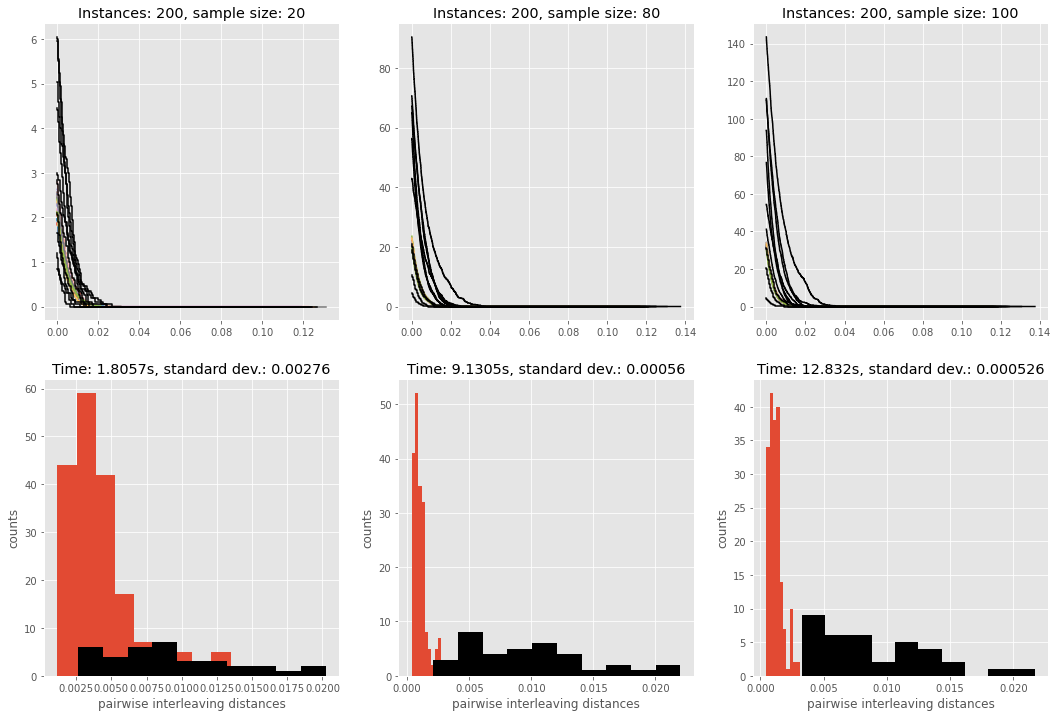

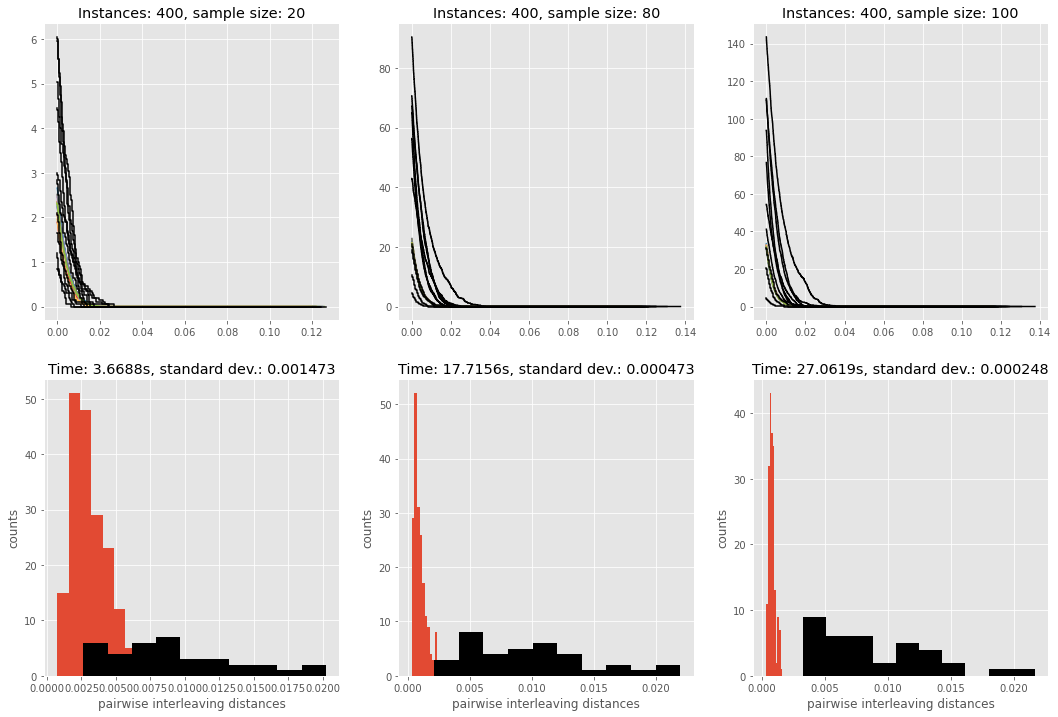

In [19]:
n = 20
sample_sizes = [20, 80, 100] #[4, 8]
numbers_instances = [20, 100, 200, 400] #[5, 10, 2]
#sample_sizes = [4, 8]
#numbers_instances = [2, 5, 10]

hsr_subjects = dict()
range_of_subjects = range(2, 12)

for k in range(len(sample_sizes)):
    sample_size = sample_sizes[k]
    sample = sr.get_sample(number_instances = 20, sample_size = sample_size, probabilities = 200)
    
    hsr_subjects[sample_size] = dict()
    
    for subject in tqdm(range_of_subjects):
        dist_mat = data.DistanceMatrix(subject = subject,
                                       method = "filtered_delayedPearson\\FDP_delay1",
                                       symmetrization = "transpose_multiplication").dist_mat
        d = sr.Distance(dist_mat)
        barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
        hsr_subjects[sample_size][subject] = sr.bc_to_sr(barcode, degree = "H1")
    
dist_mat = data.DistanceMatrix(subject = 1, 
                               method = "filtered_delayedPearson\\FDP_delay1", 
                               symmetrization = "transpose_multiplication").dist_mat
d = sr.Distance(dist_mat)

execution_times = []
stds = []

for j in range(len(numbers_instances)):
    number_instances = numbers_instances[j]
    
    fig, ax = plt.subplots(2, len(sample_sizes), figsize=(len(sample_sizes)*6, 2*6))
    
    for k in range(len(sample_sizes)):
        sample_size = sample_sizes[k]
        
        hsr = dict()
        
        start = time.time()
        for i in tqdm(range(n)):
            sample = sr.get_sample(number_instances, sample_size, 200)
            barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
            hsr[i] = sr.bc_to_sr(barcode, degree = "H1")
            hsr[i].plot(ax = ax[0, k])
        end = time.time()
        for subject in range_of_subjects:
            hsr_subjects[sample_size][subject].plot(ax = ax[0, k], color = 'k')
            
        interleaving_dists = []
        interleaving_dists_subjects = []
        
        for i in range(n):
            for j in range(i+1, n):
                interleaving_dists.append(hsr[i].interleaving_distance(hsr[j]))
        for i in range_of_subjects:
            for j in range(i+1, range_of_subjects[-1]):
                interleaving_dists_subjects.append(hsr_subjects[sample_size][i].interleaving_distance(hsr_subjects[sample_size][j]))
        
        std = np.std(np.array(interleaving_dists))
        stds.append(std)
        
        #ax[0, k].set_xlim(0.8, 1.0)
        ax[0, k].set_title("Instances: "+str(number_instances)+", sample size: "+str(round(sample_size, 4)))
        
        ax[1, k].hist(interleaving_dists, bins = 10)
        ax[1, k].hist(interleaving_dists_subjects, color = 'k', bins = 10)
        ax[1, k].set_title("Time: "+str(round(end-start, 4))+"s, standard dev.: "+str(round(std,6)))
        ax[1, k].set_xlabel("pairwise interleaving distances")
        ax[1, k].set_ylabel("counts")
        
        execution_times.append(end-start)

## Two nodes, H1

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.82s/it]


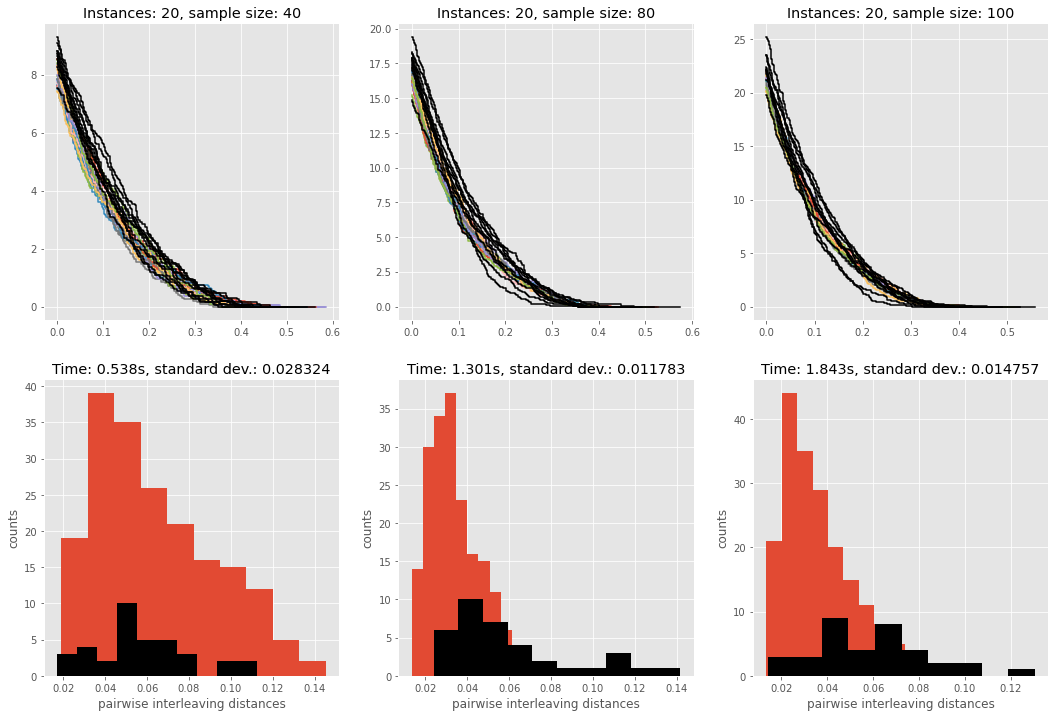

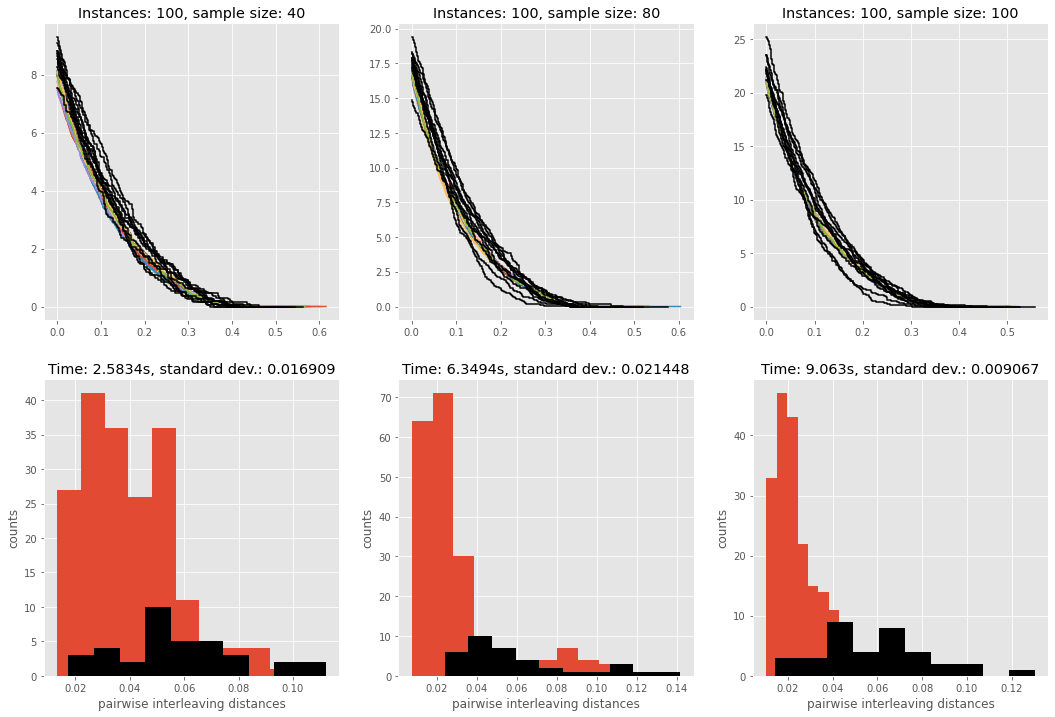

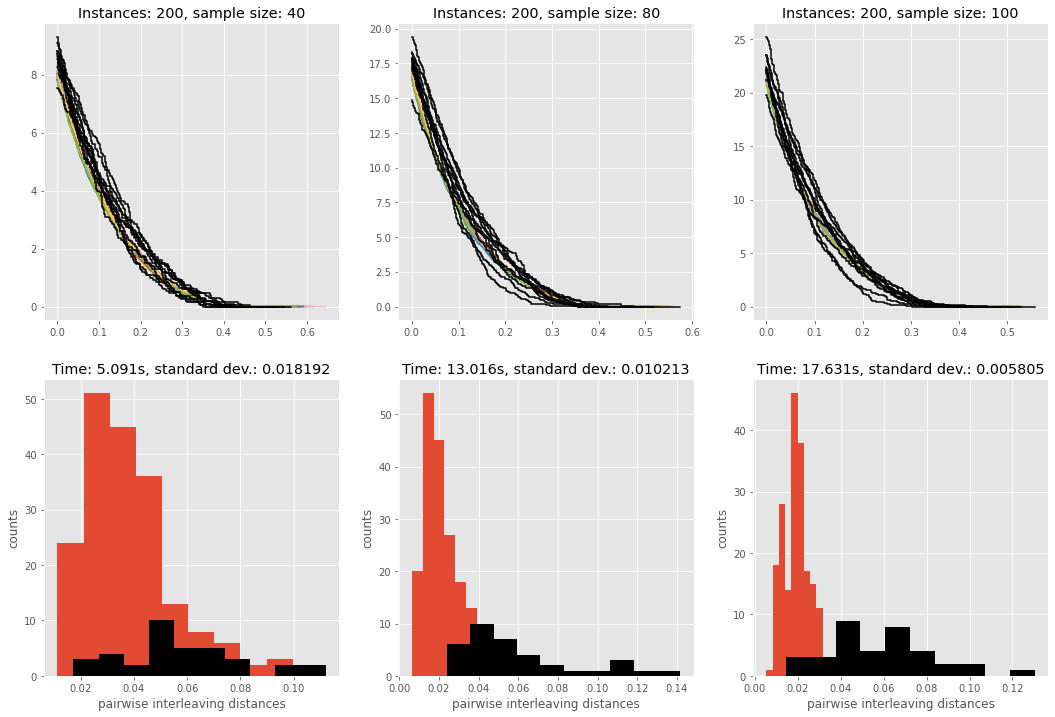

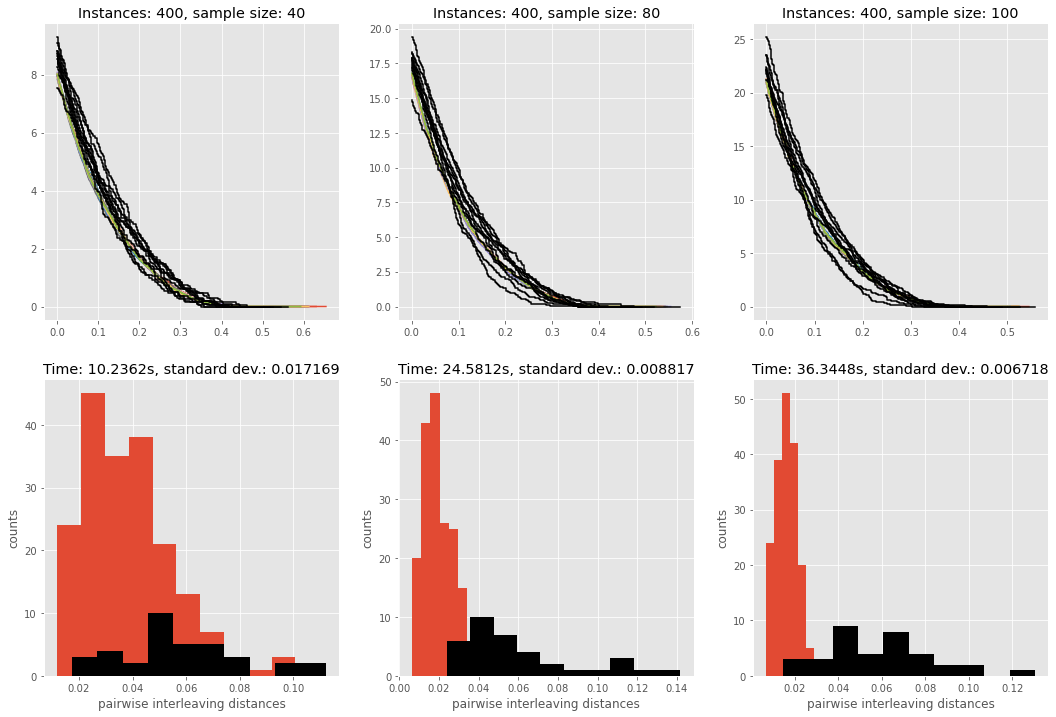

In [21]:
n = 20
sample_sizes = [40, 80, 100] #[4, 8]
numbers_instances = [20, 100, 200, 400] #[5, 10, 2]
#sample_sizes = [4, 8]
#numbers_instances = [2, 5, 10]

hsr_subjects = dict()
range_of_subjects = range(2, 12)

for k in range(len(sample_sizes)):
    sample_size = sample_sizes[k]
    sample = sr.get_sample(number_instances = 20, sample_size = sample_size, probabilities = 200)
    
    hsr_subjects[sample_size] = dict()
    
    for subject in tqdm(range_of_subjects):
        dist_mat = data.DistanceMatrix(subject = subject, 
                                       method = "filtered_delayedPearson\\FDP_delay1", 
                                       symmetrization = "two_nodes").dist_mat
        d = sr.Distance(dist_mat)
        barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
        hsr_subjects[sample_size][subject] = sr.bc_to_sr(barcode, degree = "H1")
    
dist_mat = data.DistanceMatrix(subject = 1, 
                               method = "filtered_delayedPearson\\FDP_delay1", 
                               symmetrization = "two_nodes").dist_mat
d = sr.Distance(dist_mat)

execution_times = []
stds = []

for j in range(len(numbers_instances)):
    number_instances = numbers_instances[j]
    
    fig, ax = plt.subplots(2, len(sample_sizes), figsize=(len(sample_sizes)*6, 2*6))
    
    for k in range(len(sample_sizes)):
        sample_size = sample_sizes[k]
        
        hsr = dict()
        
        start = time.time()
        for i in tqdm(range(n)):
            sample = sr.get_sample(number_instances, sample_size, 200)
            barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
            hsr[i] = sr.bc_to_sr(barcode, degree = "H1")
            hsr[i].plot(ax = ax[0, k])
        end = time.time()
        for subject in range_of_subjects:
            hsr_subjects[sample_size][subject].plot(ax = ax[0, k], color = 'k')
            
        interleaving_dists = []
        interleaving_dists_subjects = []
        
        for i in range(n):
            for j in range(i+1, n):
                interleaving_dists.append(hsr[i].interleaving_distance(hsr[j]))
        for i in range_of_subjects:
            for j in range(i+1, range_of_subjects[-1]):
                interleaving_dists_subjects.append(hsr_subjects[sample_size][i].interleaving_distance(hsr_subjects[sample_size][j]))
        
        std = np.std(np.array(interleaving_dists))
        stds.append(std)
        
        #ax[0, k].set_xlim(0.8, 1.0)
        ax[0, k].set_title("Instances: "+str(number_instances)+", sample size: "+str(round(sample_size, 4)))
        
        ax[1, k].hist(interleaving_dists, bins = 10)
        ax[1, k].hist(interleaving_dists_subjects, color = 'k', bins = 10)
        ax[1, k].set_title("Time: "+str(round(end-start, 4))+"s, standard dev.: "+str(round(std,6)))
        ax[1, k].set_xlabel("pairwise interleaving distances")
        ax[1, k].set_ylabel("counts")
        
        execution_times.append(end-start)

## Antisymmetric, H1

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:41<00:00,  2.09s/it]


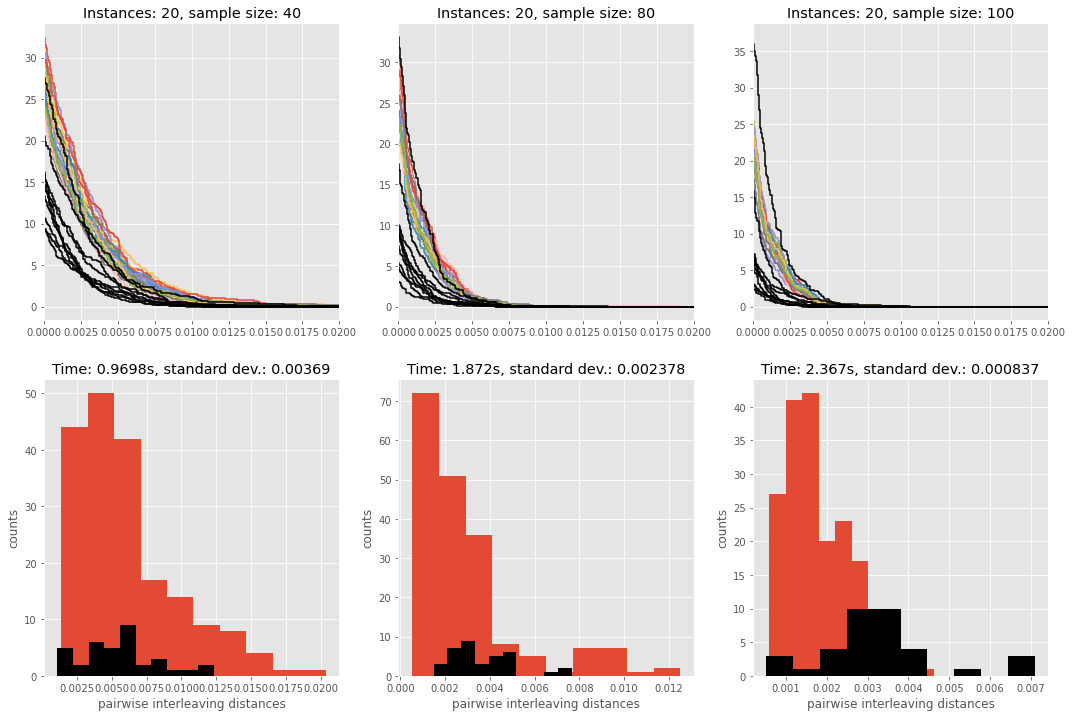

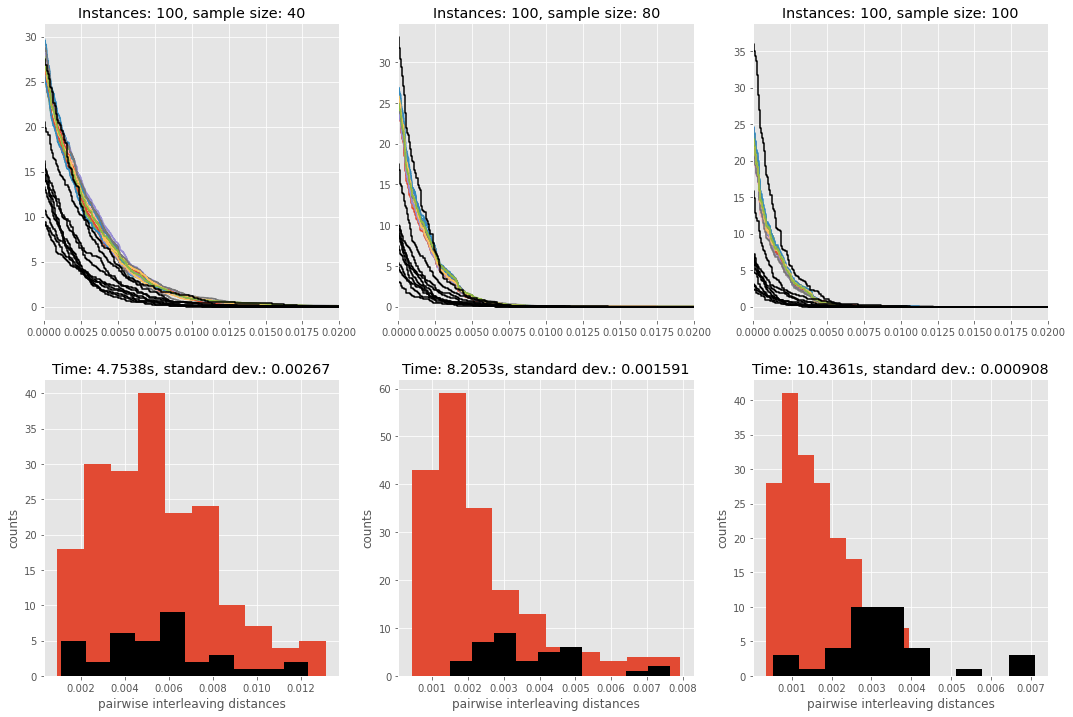

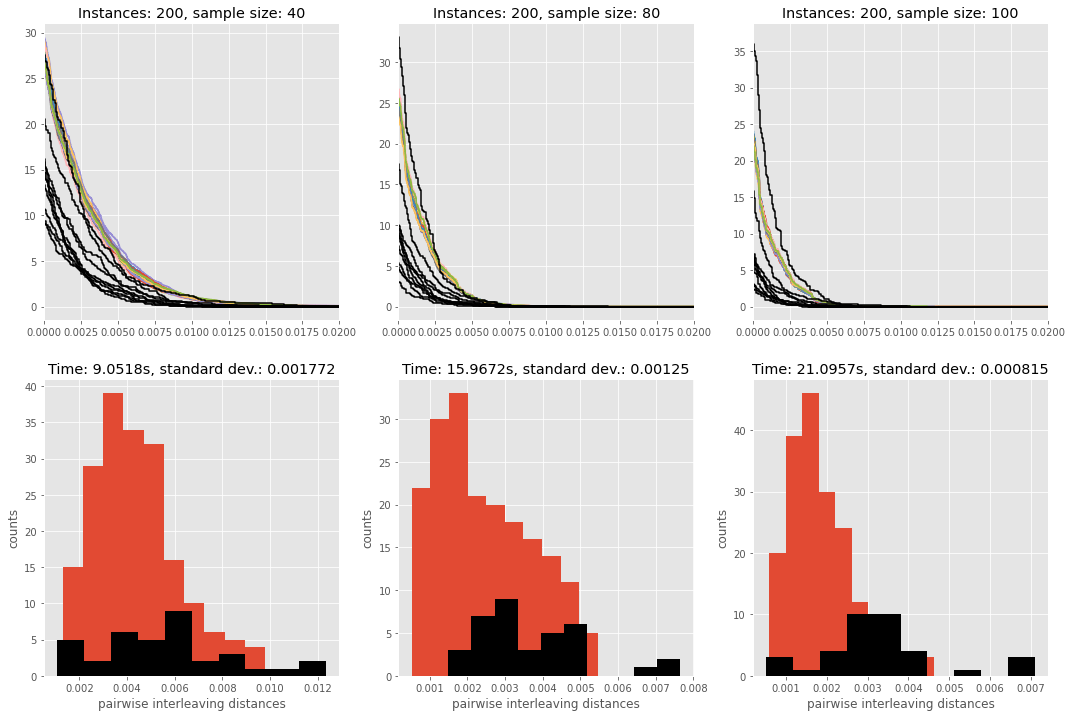

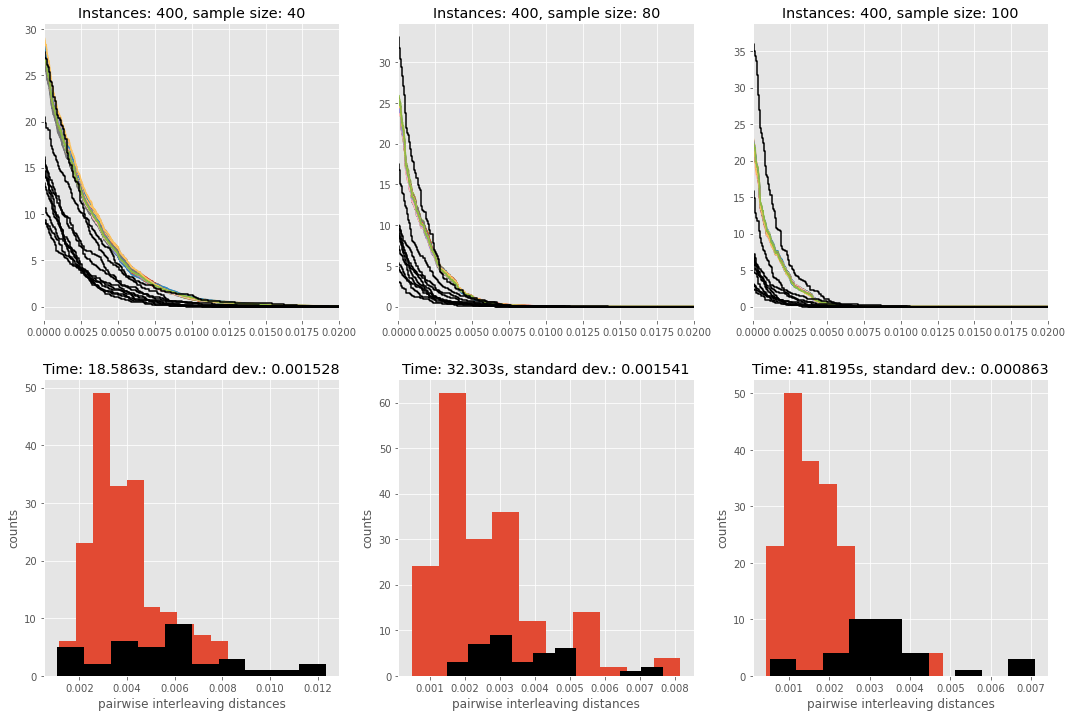

In [54]:
n = 20
sample_sizes = [40, 80, 100] #[4, 8]
numbers_instances = [20, 100, 200, 400] #[5, 10, 2]
#sample_sizes = [4, 8]
#numbers_instances = [2, 5, 10]

hsr_subjects = dict()
range_of_subjects = range(2, 12)

for k in range(len(sample_sizes)):
    sample_size = sample_sizes[k]
    sample = sr.get_sample(number_instances = 20, sample_size = sample_size, probabilities = 200)
    
    hsr_subjects[sample_size] = dict()
    
    for subject in tqdm(range_of_subjects):
        dist_mat = data.DistanceMatrix(subject = subject, 
                                       method = "filtered_delayedPearson\\FDP_delay1", 
                                       symmetrization = "antisymmetric_part").dist_mat
        d = sr.Distance(dist_mat)
        barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
        hsr_subjects[sample_size][subject] = sr.bc_to_sr(barcode, degree = "H1")
    
dist_mat = data.DistanceMatrix(subject = 1,
                               method = "filtered_delayedPearson\\FDP_delay1", 
                               symmetrization = "antisymmetric_part").dist_mat
d = sr.Distance(dist_mat)

execution_times = []
stds = []

for j in range(len(numbers_instances)):
    number_instances = numbers_instances[j]
    
    fig, ax = plt.subplots(2, len(sample_sizes), figsize=(len(sample_sizes)*6, 2*6))
    
    for k in range(len(sample_sizes)):
        sample_size = sample_sizes[k]
        
        hsr = dict()
        
        start = time.time()
        for i in tqdm(range(n)):
            sample = sr.get_sample(number_instances, sample_size, 200)
            barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
            hsr[i] = sr.bc_to_sr(barcode, degree = "H1")
            hsr[i].plot(ax = ax[0, k])
        end = time.time()
        for subject in range_of_subjects:
            hsr_subjects[sample_size][subject].plot(ax = ax[0, k], color = 'k')
            
        interleaving_dists = []
        interleaving_dists_subjects = []
        
        for i in range(n):
            for j in range(i+1, n):
                interleaving_dists.append(hsr[i].interleaving_distance(hsr[j]))
        for i in range_of_subjects:
            for j in range(i+1, range_of_subjects[-1]):
                interleaving_dists_subjects.append(hsr_subjects[sample_size][i].interleaving_distance(hsr_subjects[sample_size][j]))
        
        std = np.std(np.array(interleaving_dists))
        stds.append(std)
        
        #ax[0, k].set_xlim(0.8, 1.0)
        ax[0, k].set_title("Instances: "+str(number_instances)+", sample size: "+str(round(sample_size, 4)))
        ax[0, k].set_xlim(0, 0.02)
        
        ax[1, k].hist(interleaving_dists, bins = 10)
        ax[1, k].hist(interleaving_dists_subjects, color = 'k', bins = 10)
        ax[1, k].set_title("Time: "+str(round(end-start, 4))+"s, standard dev.: "+str(round(std,6)))
        ax[1, k].set_xlabel("pairwise interleaving distances")
        ax[1, k].set_ylabel("counts")
        
        execution_times.append(end-start)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:36<00:00, 10.84s/it]


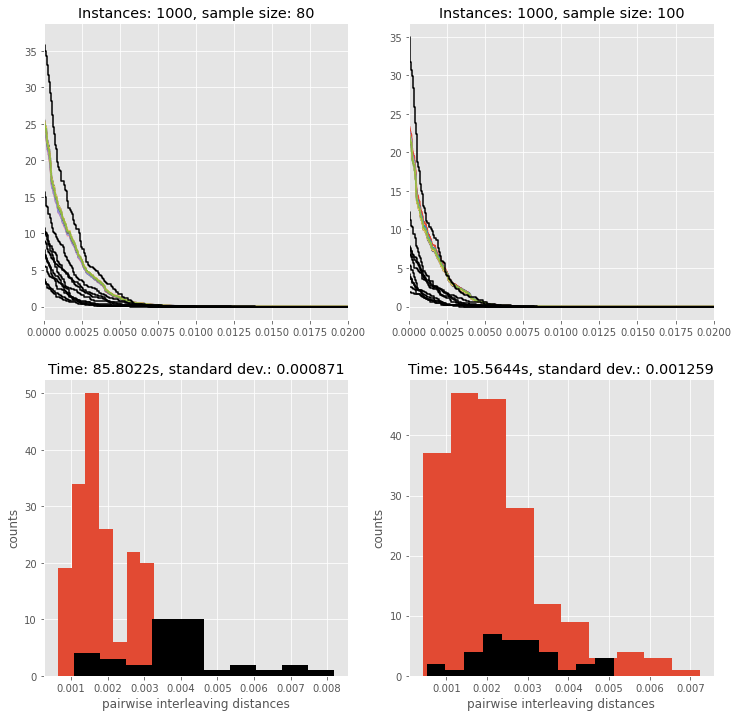

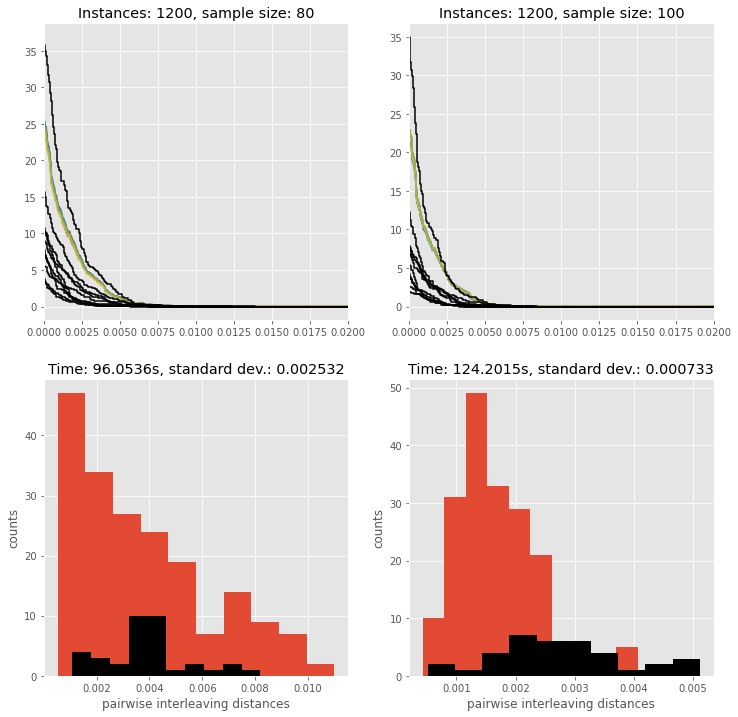

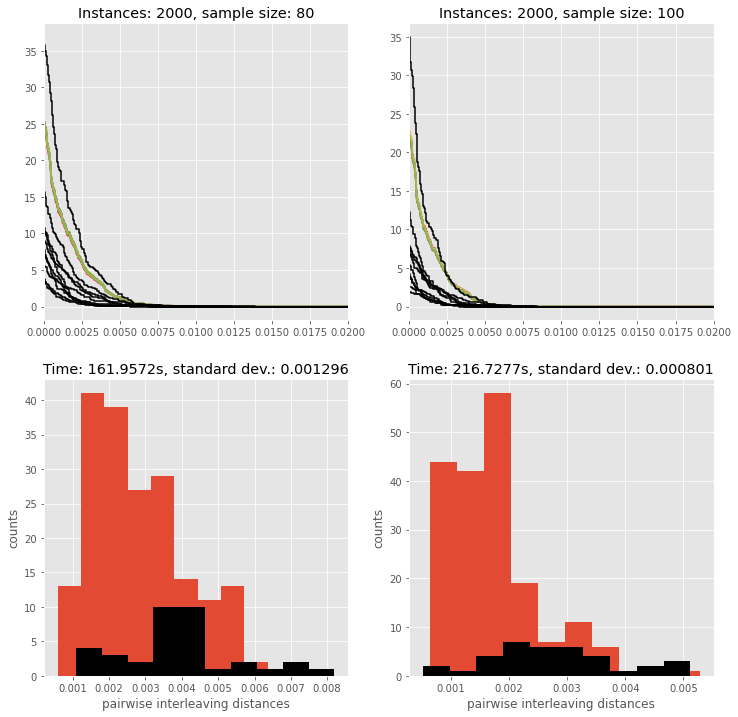

In [55]:
n = 20
sample_sizes = [80, 100] #[4, 8]
numbers_instances = [1000, 1200, 2000] #[5, 10, 2]
#sample_sizes = [4, 8]
#numbers_instances = [2, 5, 10]

hsr_subjects = dict()
range_of_subjects = range(2, 12)

for k in range(len(sample_sizes)):
    sample_size = sample_sizes[k]
    sample = sr.get_sample(number_instances = 20, sample_size = sample_size, probabilities = 200)
    
    hsr_subjects[sample_size] = dict()
    
    for subject in tqdm(range_of_subjects):
        dist_mat = data.DistanceMatrix(subject = subject, 
                                       method = "filtered_delayedPearson\\FDP_delay1", 
                                       symmetrization = "antisymmetric_part").dist_mat
        d = sr.Distance(dist_mat)
        barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
        hsr_subjects[sample_size][subject] = sr.bc_to_sr(barcode, degree = "H1")
    
dist_mat = data.DistanceMatrix(subject = 1, 
                               method = "filtered_delayedPearson\\FDP_delay1", 
                               symmetrization = "antisymmetric_part").dist_mat
d = sr.Distance(dist_mat)

execution_times = []
stds = []

for j in range(len(numbers_instances)):
    number_instances = numbers_instances[j]
    
    fig, ax = plt.subplots(2, len(sample_sizes), figsize=(len(sample_sizes)*6, 2*6))
    
    for k in range(len(sample_sizes)):
        sample_size = sample_sizes[k]
        
        hsr = dict()
        
        start = time.time()
        for i in tqdm(range(n)):
            sample = sr.get_sample(number_instances, sample_size, 200)
            barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
            hsr[i] = sr.bc_to_sr(barcode, degree = "H1")
            hsr[i].plot(ax = ax[0, k])
        end = time.time()
        for subject in range_of_subjects:
            hsr_subjects[sample_size][subject].plot(ax = ax[0, k], color = 'k')
            
        interleaving_dists = []
        interleaving_dists_subjects = []
        
        for i in range(n):
            for j in range(i+1, n):
                interleaving_dists.append(hsr[i].interleaving_distance(hsr[j]))
        for i in range_of_subjects:
            for j in range(i+1, range_of_subjects[-1]):
                interleaving_dists_subjects.append(hsr_subjects[sample_size][i].interleaving_distance(hsr_subjects[sample_size][j]))
        
        std = np.std(np.array(interleaving_dists))
        stds.append(std)
        
        #ax[0, k].set_xlim(0.8, 1.0)
        ax[0, k].set_title("Instances: "+str(number_instances)+", sample size: "+str(round(sample_size, 4)))
        ax[0, k].set_xlim(0, 0.02)
        
        ax[1, k].hist(interleaving_dists, bins = 10)
        ax[1, k].hist(interleaving_dists_subjects, color = 'k', bins = 10)
        ax[1, k].set_title("Time: "+str(round(end-start, 4))+"s, standard dev.: "+str(round(std,6)))
        ax[1, k].set_xlabel("pairwise interleaving distances")
        ax[1, k].set_ylabel("counts")
        
        execution_times.append(end-start)

# Check indices matrices with time series

In [22]:
delay = 1
for subject in tqdm(range(1,107)):
    fmri = data.TimeSeries(subject=subject)
    ts_based = data._compute_cor_df_delayedPearson_(fmri_df=fmri.data_df, delay=1)
    
    filename = "data/DistanceMatrices_PD/delayedPearson/C200_delay"+str(delay)+"/C200_delay"+str(delay)+"_Subject_"+str(subject)
    dm_based = pd.read_csv(filename, header=None)
    
    if not (abs(ts_based - dm_based).all().all() < 1e-3):
        print(subject)
        break


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [05:54<00:00,  3.34s/it]


# Investigate stable ranks

## Filtered delayed Pearson

### Transpose multiplication

In [3]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects1 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "delayedPearson\\C200_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "transpose_multiplication").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects1[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [03:43<00:00,  2.11s/it]


(0.0, 0.02)

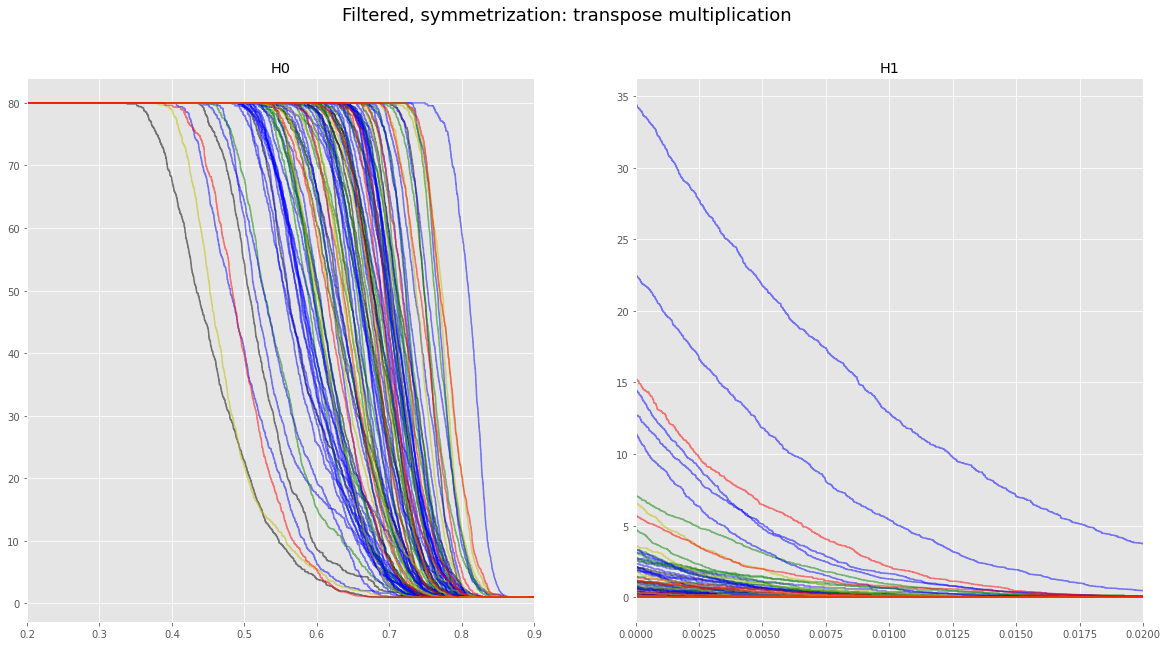

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Filtered, symmetrization: transpose multiplication", fontsize=18)

for subject in range_of_subjects:
    hsr_subjects1[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects1[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.2, 0.9)
ax[1].set_xlim(0, 0.02)

### Maximum

In [5]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects2 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "filtered_delayedPearson\\FDP_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "maximum").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects2[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [08:15<00:00,  4.67s/it]


(0.0, 0.2)

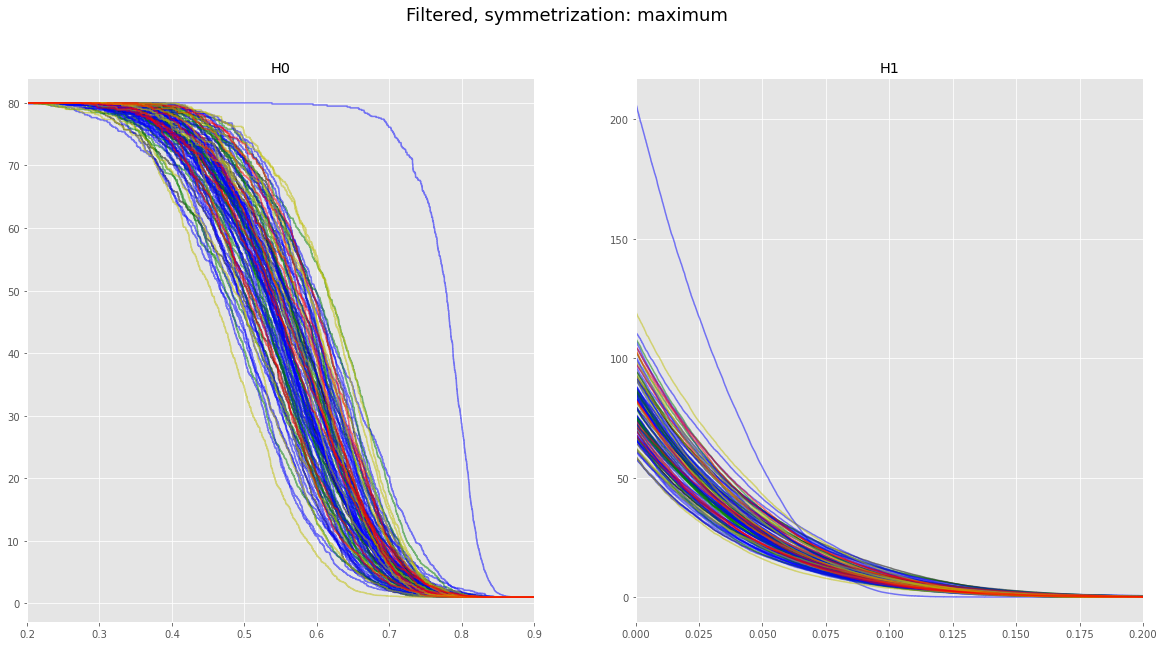

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Filtered, symmetrization: maximum", fontsize=18)

for subject in range_of_subjects:
    hsr_subjects2[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects2[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.2, 0.9)
ax[1].set_xlim(0, 0.2)

### Symmetric part

In [7]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects3 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "filtered_delayedPearson\\FDP_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "symmetric_part").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects3[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [07:52<00:00,  4.46s/it]


(0.0, 0.2)

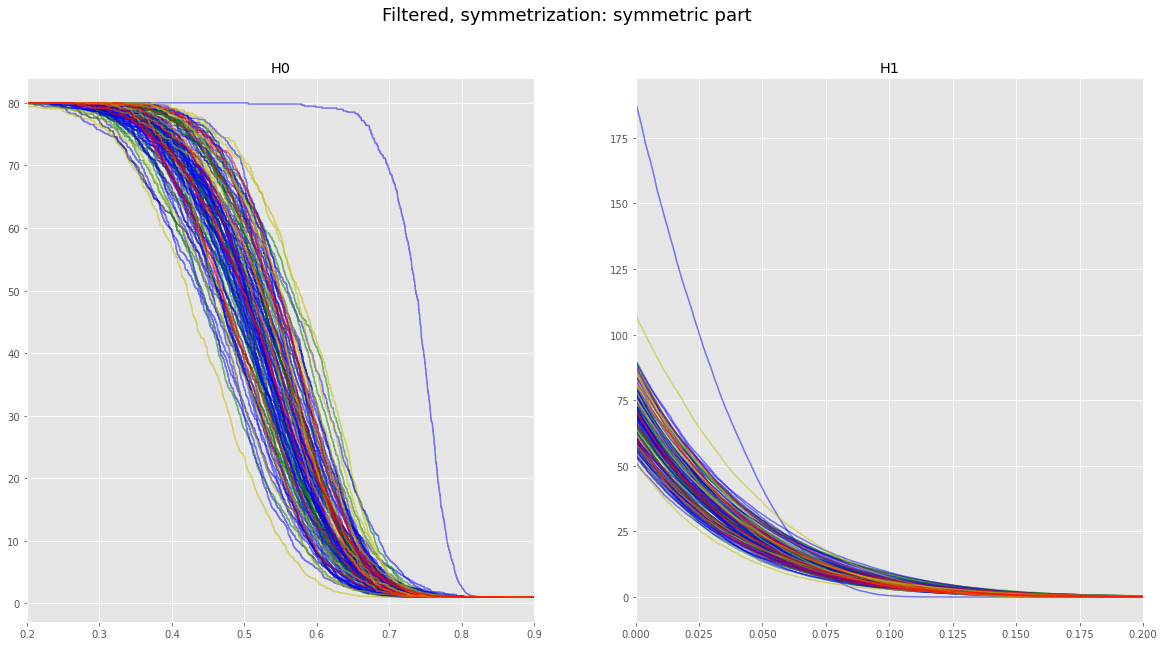

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Filtered, symmetrization: symmetric part", fontsize=18) 

for subject in range_of_subjects:
    hsr_subjects3[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects3[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.2, 0.9)
ax[1].set_xlim(0, 0.2)

### Antisymmetric part

In [9]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects4 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "filtered_delayedPearson\\FDP_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "antisymmetric_part").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects4[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [24:42<00:00, 13.99s/it]


(0.0, 0.03)

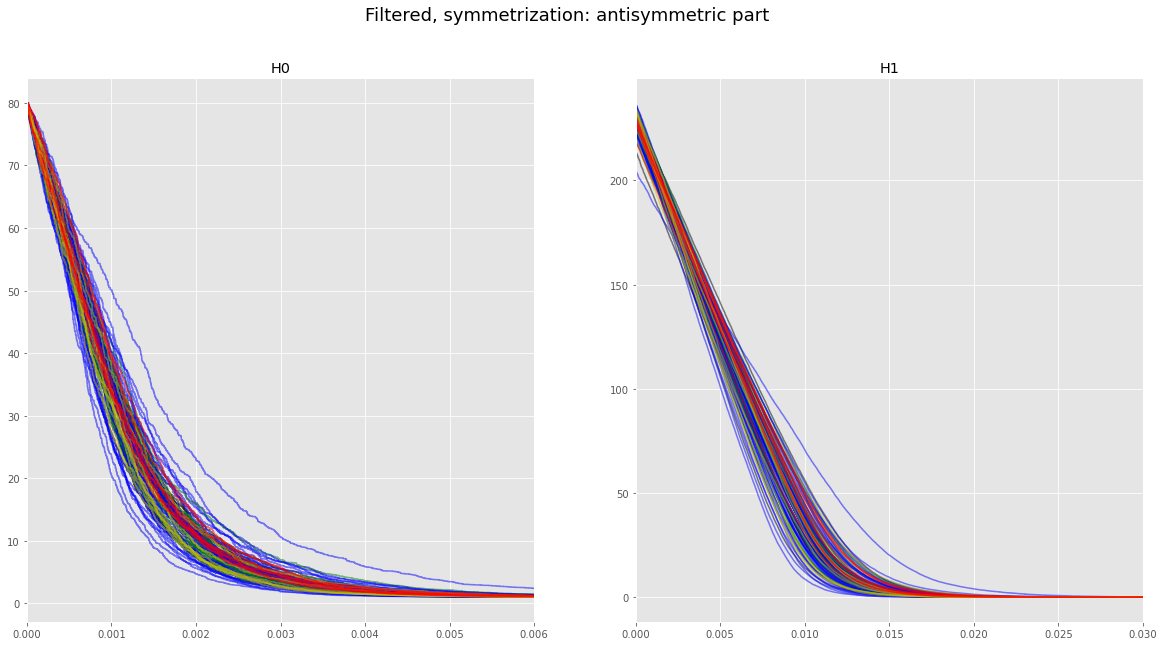

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Filtered, symmetrization: antisymmetric part", fontsize=18) 

for subject in range_of_subjects:
    hsr_subjects4[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects4[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0, 0.006)
ax[1].set_xlim(0, 0.03)

### Two nodes

In [11]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects5 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "filtered_delayedPearson\\FDP_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "two_nodes").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects5[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [02:28<00:00,  1.41s/it]


(0.0, 0.4)

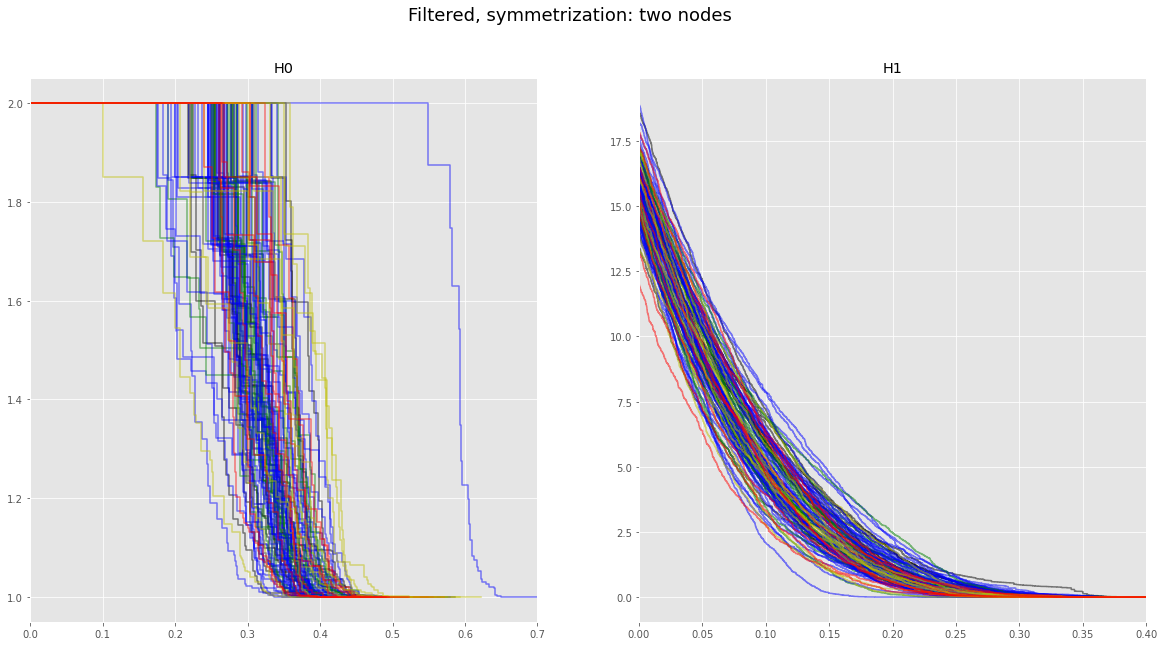

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Filtered, symmetrization: two nodes", fontsize = 18) 

for subject in range_of_subjects:
    hsr_subjects5[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects5[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0, 0.7)
ax[1].set_xlim(0, 0.4)

## Unfiltered delayed Pearson

### Transpose multiplication

In [13]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects6 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "delayedPearson\\C200_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "transpose_multiplication").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects6[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [03:47<00:00,  2.14s/it]


(0.0, 0.04)

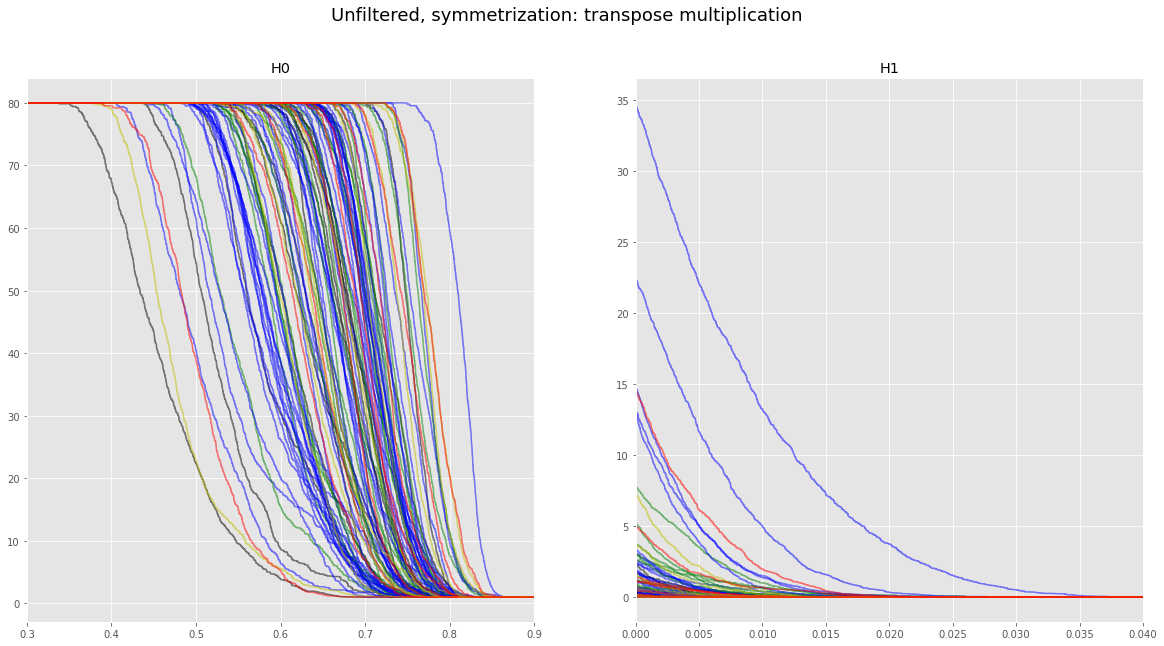

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Unfiltered, symmetrization: transpose multiplication", fontsize=18)

for subject in range_of_subjects:
    hsr_subjects6[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects6[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.3, 0.9)
ax[1].set_xlim(0, 0.04)

### Symmetric part

In [15]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects8 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "delayedPearson\\C200_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "symmetric_part").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects8[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [06:37<00:00,  3.75s/it]


(0.0, 0.2)

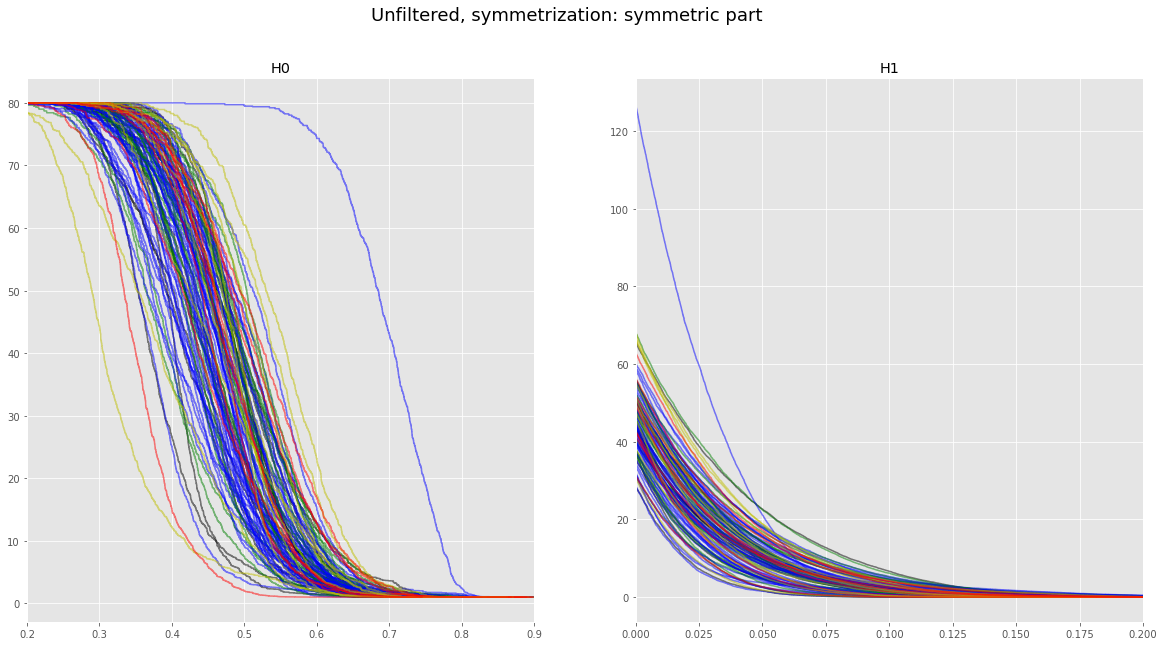

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Unfiltered, symmetrization: symmetric part", fontsize=18) 

for subject in range_of_subjects:
    hsr_subjects8[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects8[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.2, 0.9)
ax[1].set_xlim(0, 0.2)

### Antisymmetric part

In [17]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects9 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "delayedPearson\\C200_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "antisymmetric_part").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects9[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [21:12<00:00, 12.01s/it]


(0.0, 0.03)

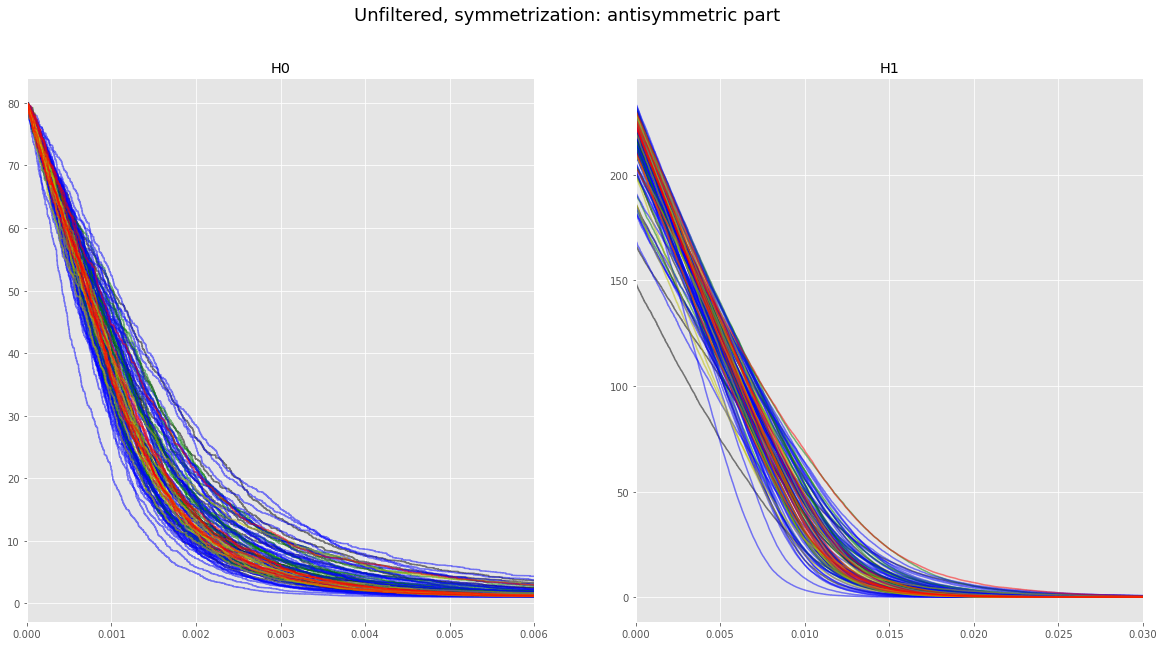

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Unfiltered, symmetrization: antisymmetric part", fontsize=18) 

for subject in range_of_subjects:
    hsr_subjects9[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects9[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0, 0.006)
ax[1].set_xlim(0, 0.03)

## Filtered DTW (already symmetric)

In [19]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects11 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "filtered_dtw", 
                                   neg_vals_method = "abs").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects11[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [05:12<00:00,  2.95s/it]


(0.0, 0.05)

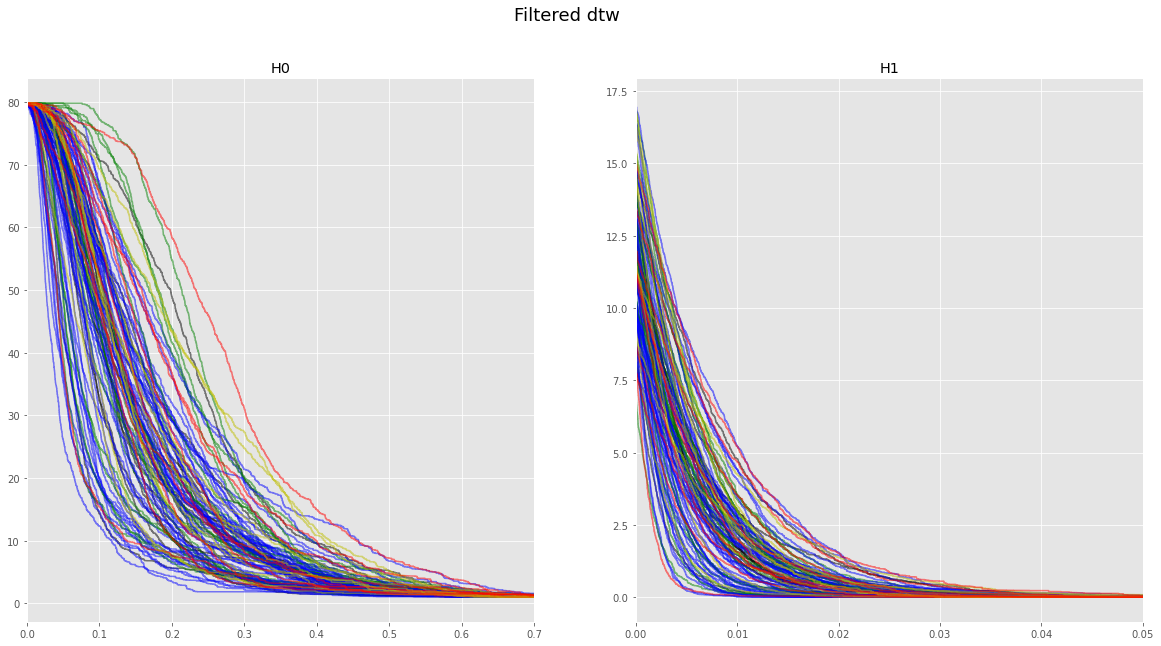

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Filtered dtw", fontsize = 18) 

for subject in range_of_subjects:
    hsr_subjects11[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects11[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0, 0.7)
ax[1].set_xlim(0, 0.05)

### Clip zero

In [21]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects12 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "filtered_dtw", 
                                   neg_vals_method = "clip_zero").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects12[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [04:54<00:00,  2.78s/it]


(0.0, 0.05)

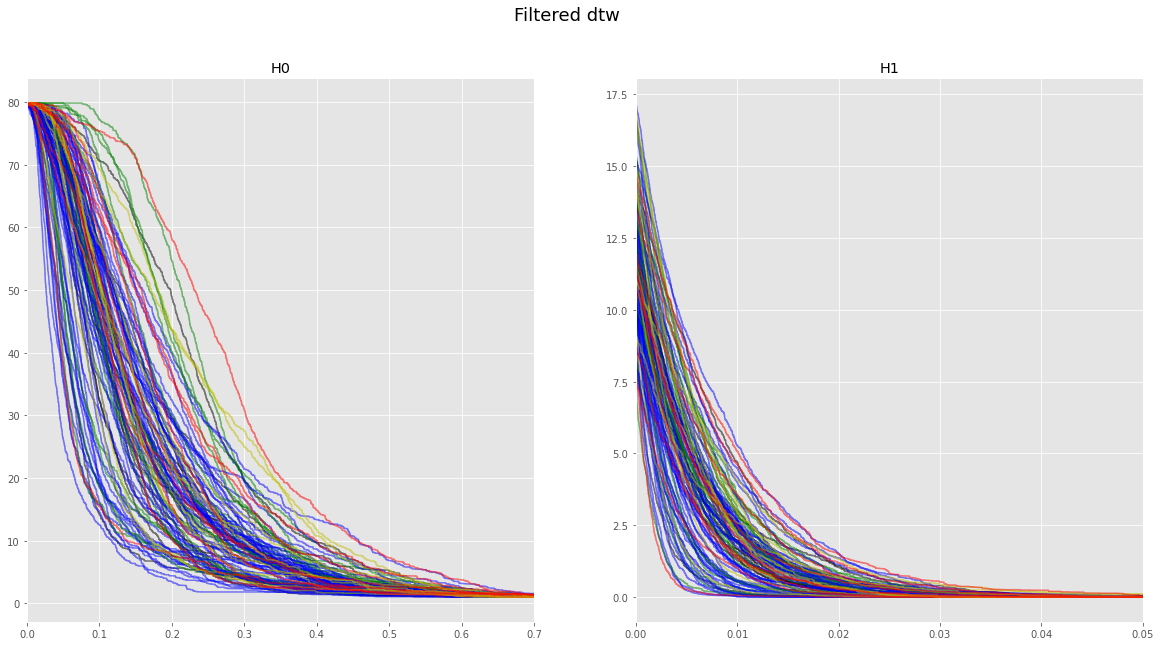

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Filtered dtw", fontsize = 18) 

for subject in range_of_subjects:
    hsr_subjects12[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects12[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0, 0.7)
ax[1].set_xlim(0, 0.05)

## Unfiltered DTW (already symmetric)

In [23]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects13 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "dtw", 
                                   neg_vals_method = "abs").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects13[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [05:21<00:00,  3.04s/it]


(0.0, 0.04)

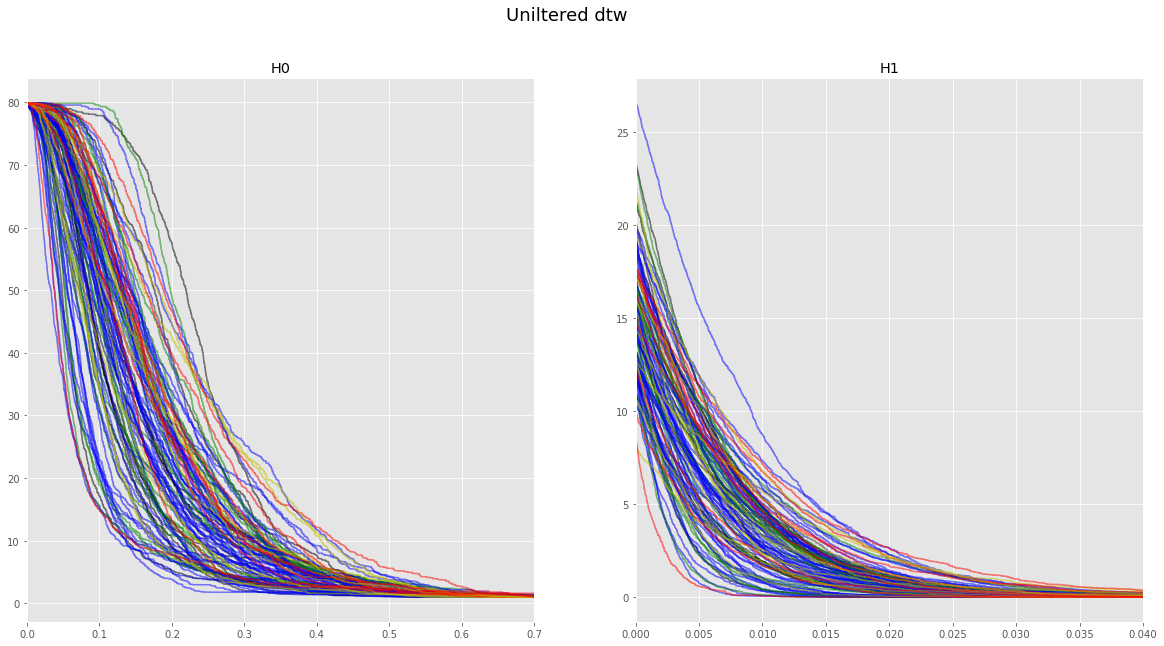

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Uniltered dtw", fontsize = 18) 

for subject in range_of_subjects:
    hsr_subjects13[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects13[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0, 0.7)
ax[1].set_xlim(0, 0.04)

# Get indices of lines above "hole" in stable rank plot

(0.0, 0.05)

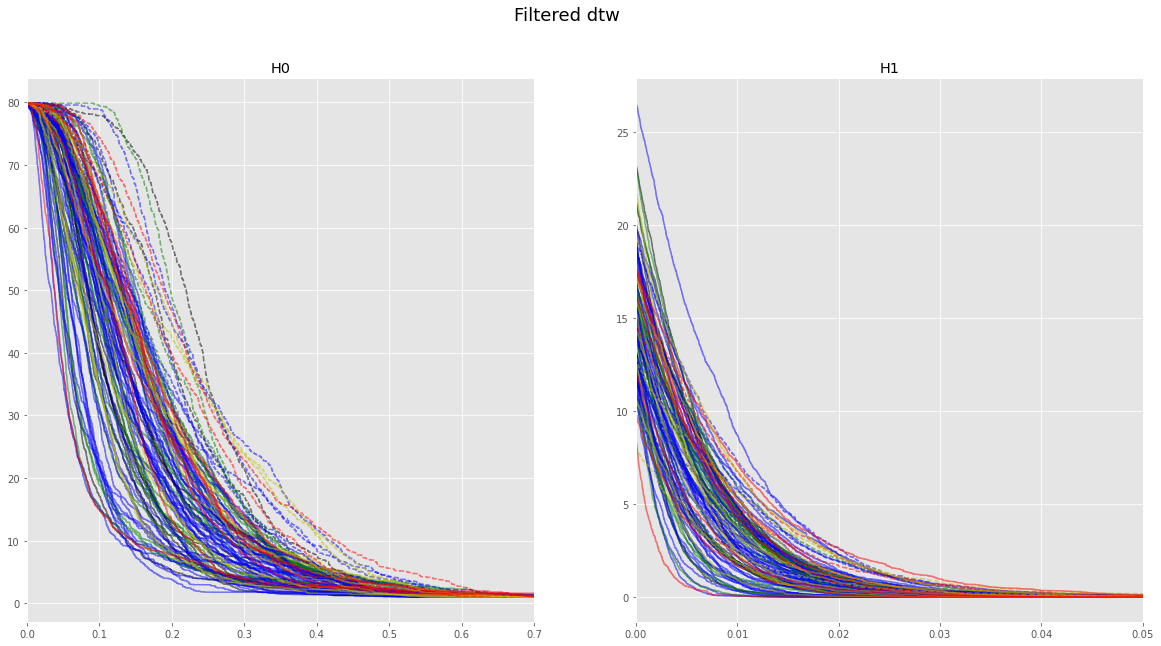

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Filtered dtw", fontsize = 18) 

selected_subjects = []
for subject in range_of_subjects:
    if hsr_subjects13[subject][0].evaluate(0.175) > 40:
        hsr_subjects13[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5, linestyle = "--")
        hsr_subjects13[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5, linestyle = "--")
        selected_subjects.append(subject)
    else:
        hsr_subjects13[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
        hsr_subjects13[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0, 0.7)
ax[1].set_xlim(0, 0.05)

In [26]:
labels_selected_subjects = []
for subject in selected_subjects:
    labels_selected_subjects.append(labels[subject])

In [27]:
selected_subjects

[10, 13, 18, 35, 42, 51, 53, 58, 82, 83, 88, 93, 94, 101]

In [28]:
labels_selected_subjects

['CTR',
 'CTR',
 'PD_CN_med',
 'PD_CN_med',
 'PD_CN_med',
 'PD_CN_nonMed',
 'PD_CN_nonMed',
 'PD_CN_med',
 'PD_CN_nonMed',
 'PD_CN_med',
 'PD_MCI_med',
 'PD_MCI_nonMed',
 'PD_MCI_med',
 'PD_MCI_nonMed']

# Reinvestigating the most interesting stable rank plot

In [29]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects14 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "delayedPearson\\C200_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "antisymmetric_part").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects14[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [21:31<00:00, 12.19s/it]


(0.0, 0.03)

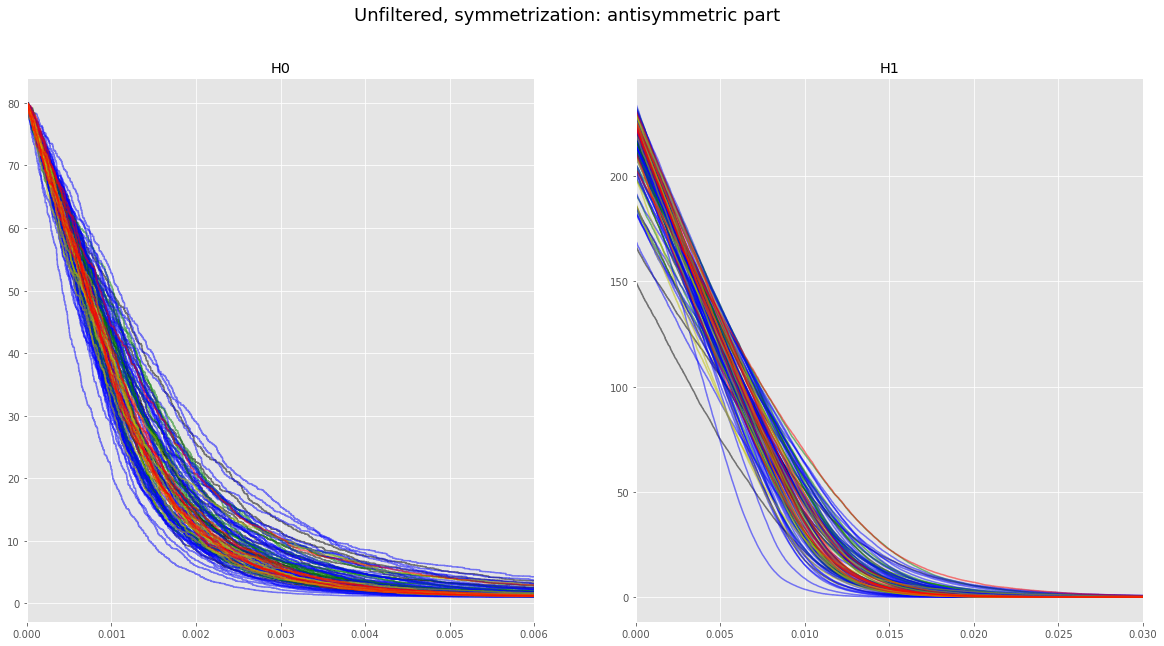

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Unfiltered, symmetrization: antisymmetric part", fontsize=18) 

for subject in range_of_subjects:
    hsr_subjects14[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects14[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
#ax[0].set_xlim(0.002, 0.0025)
#ax[0].set_ylim(0, 30)
ax[0].set_xlim(0, 0.006)
ax[1].set_xlim(0, 0.03)

(0.0, 0.03)

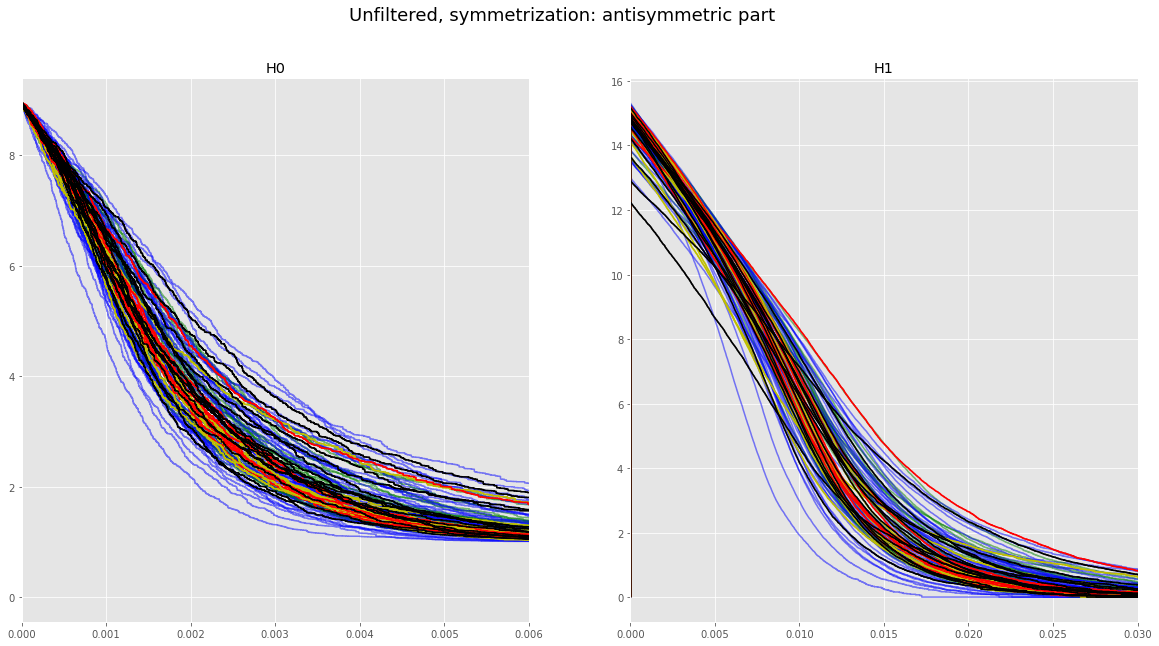

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Unfiltered, symmetrization: antisymmetric part", fontsize=18) 

for subject in range_of_subjects:
    hsr0 = hsr_subjects14[subject][0]
    hsr0.__pow__(0.5).plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    
    hsr1 = hsr_subjects14[subject][1]
    hsr1.__pow__(0.5).plot(ax = ax[1], color = colors[subject], alpha = 0.5)

for subject in range(88,107):
    hsr0 = hsr_subjects14[subject][0]
    hsr0.__pow__(0.5).plot(ax = ax[0], color = colors[subject], alpha = 1)
    
    hsr1 = hsr_subjects14[subject][1]
    hsr1.__pow__(0.5).plot(ax = ax[1], color = colors[subject], alpha = 1)
    
for subject in range(1, 16):
    hsr0 = hsr_subjects14[subject][0]
    hsr0.__pow__(0.5).plot(ax = ax[0], color = colors[subject], alpha = 1)
    
    hsr1 = hsr_subjects14[subject][1]
    hsr1.__pow__(0.5).plot(ax = ax[1], color = colors[subject], alpha = 1)
    
ax[0].set_title("H0")
ax[1].set_title("H1")
#ax[0].set_xlim(0.002, 0.0025)
#ax[0].set_ylim(0, 30)
ax[0].set_xlim(0, 0.006)
ax[1].set_xlim(0, 0.03)

# Different clustering methods

In [32]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects15 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "filtered_delayedPearson\\FDP_delay1", 
                                   neg_vals_method = "abs", 
                                   symmetrization = "antisymmetric_part").dist_mat
    d = sr.Distance(dist_mat)
    hsr_subjects15[subject] = (d.get_h0sr(sample=sample, clustering_method="single"), 
                                      d.get_h0sr(sample=sample, clustering_method="complete"),
                                      d.get_h0sr(sample=sample, clustering_method="average"),
                                      d.get_h0sr(sample=sample, clustering_method="ward")) 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [14:46<00:00,  8.37s/it]


(0.0, 0.2)

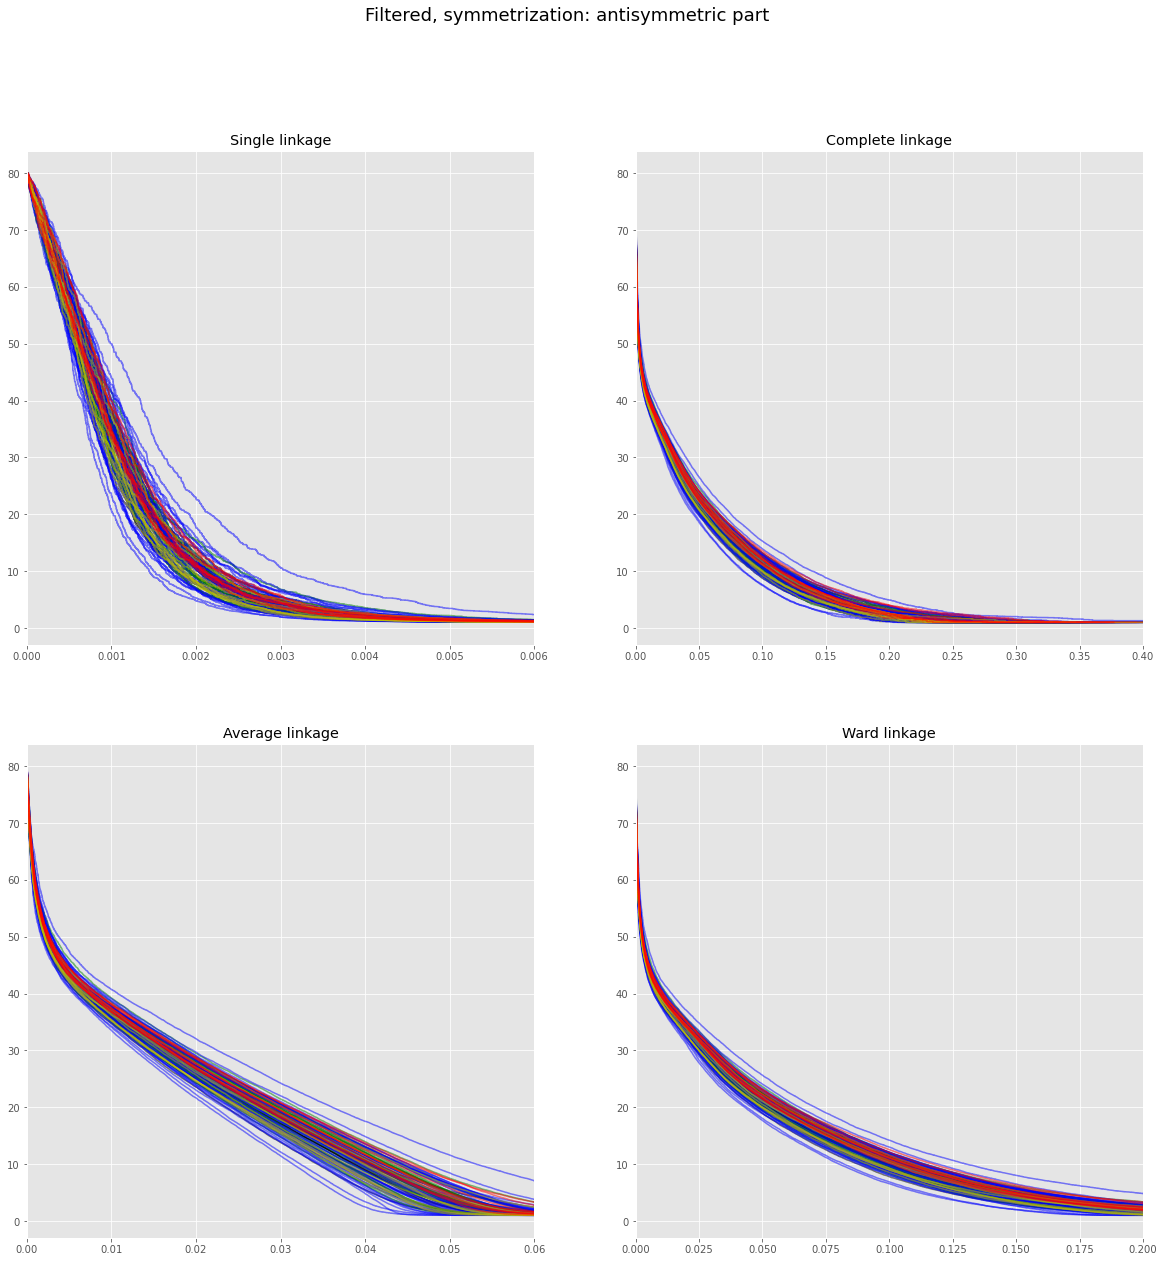

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle("Filtered, symmetrization: antisymmetric part", fontsize=18) 

for subject in range_of_subjects:
    hsr_subjects15[subject][0].plot(ax = ax[0,0], color = colors[subject], alpha = 0.5)
    hsr_subjects15[subject][1].plot(ax = ax[0,1], color = colors[subject], alpha = 0.5)
    hsr_subjects15[subject][2].plot(ax = ax[1,0], color = colors[subject], alpha = 0.5)
    hsr_subjects15[subject][3].plot(ax = ax[1,1], color = colors[subject], alpha = 0.5)

ax[0,0].set_title("Single linkage")
ax[0,1].set_title("Complete linkage")
ax[1,0].set_title("Average linkage")
ax[1,1].set_title("Ward linkage")

ax[0,0].set_xlim(0, 0.006)
ax[0,1].set_xlim(0, 0.4)
ax[1,0].set_xlim(0, 0.06)
ax[1,1].set_xlim(0, 0.2)

# Try new symmetrization method

In [3]:
sample_size = 80 #[4, 8]
number_instances = 400 #[5, 10, 2]

hsr_subjects16 = dict()
range_of_subjects = range(1, 107)

sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

for subject in tqdm(range_of_subjects):
    dist_mat = data.DistanceMatrix(subject = subject, 
                                   method = "filtered_delayedPearson\\FDP_delay1", 
                                   neg_vals_method = None, 
                                   symmetrization = "pdist_rows").dist_mat
    d = sr.Distance(dist_mat)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects16[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

  0%|                                                                                          | 0/106 [00:00<?, ?it/s]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  1%|▊                                                                                 | 1/106 [00:20<35:42, 20.41s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  2%|█▌                                                                                | 2/106 [00:45<39:43, 22.92s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  3%|██▎                                                                               | 3/106 [01:07<39:08, 22.80s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  4%|███                                                                               | 4/106 [01:27<37:02, 21.79s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  5%|███▊                                                                              | 5/106 [01:44<33:18, 19.79s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  6%|████▋                                                                             | 6/106 [02:02<32:03, 19.24s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  7%|█████▍                                                                            | 7/106 [02:20<30:52, 18.71s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  8%|██████▏                                                                           | 8/106 [02:41<31:56, 19.55s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  8%|██████▉                                                                           | 9/106 [02:58<30:17, 18.74s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


  9%|███████▋                                                                         | 10/106 [03:16<29:29, 18.43s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 10%|████████▍                                                                        | 11/106 [03:34<29:07, 18.40s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 11%|█████████▏                                                                       | 12/106 [03:52<28:32, 18.21s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 12%|█████████▉                                                                       | 13/106 [04:15<30:38, 19.76s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 13%|██████████▋                                                                      | 14/106 [04:37<31:17, 20.41s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 14%|███████████▍                                                                     | 15/106 [04:59<31:48, 20.97s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 15%|████████████▏                                                                    | 16/106 [05:16<29:43, 19.82s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 16%|████████████▉                                                                    | 17/106 [05:42<31:51, 21.48s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 17%|█████████████▊                                                                   | 18/106 [06:01<30:37, 20.88s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 18%|██████████████▌                                                                  | 19/106 [06:21<30:00, 20.69s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 19%|███████████████▎                                                                 | 20/106 [06:42<29:35, 20.65s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 20%|████████████████                                                                 | 21/106 [07:05<30:13, 21.33s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 21%|████████████████▊                                                                | 22/106 [07:22<28:00, 20.00s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 22%|█████████████████▌                                                               | 23/106 [07:48<30:26, 22.01s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 23%|██████████████████▎                                                              | 24/106 [08:04<27:36, 20.21s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 24%|███████████████████                                                              | 25/106 [08:23<26:29, 19.63s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 25%|███████████████████▊                                                             | 26/106 [08:42<25:55, 19.45s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 25%|████████████████████▋                                                            | 27/106 [09:03<26:14, 19.93s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 26%|█████████████████████▍                                                           | 28/106 [09:23<25:57, 19.96s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 27%|██████████████████████▏                                                          | 29/106 [09:47<27:21, 21.32s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 28%|██████████████████████▉                                                          | 30/106 [10:10<27:25, 21.65s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 29%|███████████████████████▋                                                         | 31/106 [10:27<25:17, 20.23s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 30%|████████████████████████▍                                                        | 32/106 [10:52<26:59, 21.89s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 31%|█████████████████████████▏                                                       | 33/106 [11:12<25:44, 21.15s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 32%|█████████████████████████▉                                                       | 34/106 [11:31<24:32, 20.46s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 33%|██████████████████████████▋                                                      | 35/106 [11:54<25:20, 21.41s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 34%|███████████████████████████▌                                                     | 36/106 [12:13<23:51, 20.45s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 35%|████████████████████████████▎                                                    | 37/106 [12:39<25:41, 22.34s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 36%|█████████████████████████████                                                    | 38/106 [12:59<24:17, 21.44s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 37%|█████████████████████████████▊                                                   | 39/106 [13:17<22:59, 20.58s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 38%|██████████████████████████████▌                                                  | 40/106 [13:36<22:10, 20.15s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 39%|███████████████████████████████▎                                                 | 41/106 [13:56<21:40, 20.01s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 40%|████████████████████████████████                                                 | 42/106 [14:16<21:16, 19.95s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 41%|████████████████████████████████▊                                                | 43/106 [14:29<18:41, 17.79s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 42%|█████████████████████████████████▌                                               | 44/106 [14:48<18:55, 18.32s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 42%|██████████████████████████████████▍                                              | 45/106 [15:05<18:13, 17.93s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 43%|███████████████████████████████████▏                                             | 46/106 [15:22<17:37, 17.62s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 44%|███████████████████████████████████▉                                             | 47/106 [15:43<18:12, 18.52s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 45%|████████████████████████████████████▋                                            | 48/106 [16:01<17:41, 18.31s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 46%|█████████████████████████████████████▍                                           | 49/106 [16:17<16:51, 17.75s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 47%|██████████████████████████████████████▏                                          | 50/106 [16:33<15:58, 17.11s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 48%|██████████████████████████████████████▉                                          | 51/106 [16:54<16:50, 18.36s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 49%|███████████████████████████████████████▋                                         | 52/106 [17:12<16:32, 18.39s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 50%|████████████████████████████████████████▌                                        | 53/106 [17:31<16:23, 18.56s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 51%|█████████████████████████████████████████▎                                       | 54/106 [17:57<17:48, 20.56s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 52%|██████████████████████████████████████████                                       | 55/106 [18:18<17:37, 20.73s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 53%|██████████████████████████████████████████▊                                      | 56/106 [18:38<17:14, 20.68s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 54%|███████████████████████████████████████████▌                                     | 57/106 [19:02<17:40, 21.65s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 55%|████████████████████████████████████████████▎                                    | 58/106 [19:15<15:09, 18.94s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 56%|█████████████████████████████████████████████                                    | 59/106 [19:33<14:34, 18.61s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 57%|█████████████████████████████████████████████▊                                   | 60/106 [19:57<15:32, 20.27s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 58%|██████████████████████████████████████████████▌                                  | 61/106 [20:15<14:46, 19.69s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 58%|███████████████████████████████████████████████▍                                 | 62/106 [20:31<13:42, 18.70s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 59%|████████████████████████████████████████████████▏                                | 63/106 [20:51<13:38, 19.03s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 60%|████████████████████████████████████████████████▉                                | 64/106 [21:08<12:46, 18.24s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 61%|█████████████████████████████████████████████████▋                               | 65/106 [21:32<13:37, 19.93s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 62%|██████████████████████████████████████████████████▍                              | 66/106 [21:53<13:39, 20.49s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 63%|███████████████████████████████████████████████████▏                             | 67/106 [22:08<12:06, 18.64s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 64%|███████████████████████████████████████████████████▉                             | 68/106 [22:23<11:14, 17.76s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 65%|████████████████████████████████████████████████████▋                            | 69/106 [22:45<11:43, 19.01s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 66%|█████████████████████████████████████████████████████▍                           | 70/106 [23:07<11:56, 19.90s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 67%|██████████████████████████████████████████████████████▎                          | 71/106 [23:32<12:24, 21.28s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 68%|███████████████████████████████████████████████████████                          | 72/106 [23:53<12:04, 21.32s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 69%|███████████████████████████████████████████████████████▊                         | 73/106 [24:09<10:46, 19.60s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 70%|████████████████████████████████████████████████████████▌                        | 74/106 [24:31<10:53, 20.41s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 71%|█████████████████████████████████████████████████████████▎                       | 75/106 [24:49<10:06, 19.56s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 72%|██████████████████████████████████████████████████████████                       | 76/106 [25:05<09:16, 18.56s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 73%|██████████████████████████████████████████████████████████▊                      | 77/106 [25:25<09:13, 19.07s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 74%|███████████████████████████████████████████████████████████▌                     | 78/106 [25:47<09:14, 19.80s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 75%|████████████████████████████████████████████████████████████▎                    | 79/106 [26:03<08:25, 18.71s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 75%|█████████████████████████████████████████████████████████████▏                   | 80/106 [26:23<08:19, 19.19s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 76%|█████████████████████████████████████████████████████████████▉                   | 81/106 [26:43<08:02, 19.30s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 77%|██████████████████████████████████████████████████████████████▋                  | 82/106 [26:56<06:59, 17.47s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 78%|███████████████████████████████████████████████████████████████▍                 | 83/106 [27:16<07:01, 18.32s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 79%|████████████████████████████████████████████████████████████████▏                | 84/106 [27:36<06:54, 18.83s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 80%|████████████████████████████████████████████████████████████████▉                | 85/106 [27:55<06:34, 18.81s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 81%|█████████████████████████████████████████████████████████████████▋               | 86/106 [28:19<06:46, 20.30s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 82%|██████████████████████████████████████████████████████████████████▍              | 87/106 [28:38<06:22, 20.14s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 83%|███████████████████████████████████████████████████████████████████▏             | 88/106 [28:55<05:40, 18.93s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 84%|████████████████████████████████████████████████████████████████████             | 89/106 [29:14<05:25, 19.12s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 85%|████████████████████████████████████████████████████████████████████▊            | 90/106 [29:31<04:53, 18.34s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 86%|█████████████████████████████████████████████████████████████████████▌           | 91/106 [29:54<04:57, 19.84s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 87%|██████████████████████████████████████████████████████████████████████▎          | 92/106 [30:18<04:56, 21.21s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 88%|███████████████████████████████████████████████████████████████████████          | 93/106 [30:39<04:32, 20.95s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 89%|███████████████████████████████████████████████████████████████████████▊         | 94/106 [30:57<04:00, 20.07s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 90%|████████████████████████████████████████████████████████████████████████▌        | 95/106 [31:16<03:37, 19.79s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 91%|█████████████████████████████████████████████████████████████████████████▎       | 96/106 [31:33<03:11, 19.11s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 92%|██████████████████████████████████████████████████████████████████████████       | 97/106 [31:48<02:39, 17.74s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 92%|██████████████████████████████████████████████████████████████████████████▉      | 98/106 [32:06<02:22, 17.87s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 93%|███████████████████████████████████████████████████████████████████████████▋     | 99/106 [32:30<02:18, 19.78s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 94%|███████████████████████████████████████████████████████████████████████████▍    | 100/106 [32:51<02:00, 20.04s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 95%|████████████████████████████████████████████████████████████████████████████▏   | 101/106 [33:13<01:42, 20.49s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 96%|████████████████████████████████████████████████████████████████████████████▉   | 102/106 [33:28<01:15, 18.83s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 103/106 [33:50<00:59, 19.80s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 104/106 [34:12<00:41, 20.59s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


 99%|███████████████████████████████████████████████████████████████████████████████▏| 105/106 [34:35<00:21, 21.42s/it]

matrix already non-negative
correlation values exceed 1, normalizing matrix between 0 and 1


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [34:53<00:00, 19.75s/it]


(0.0, 0.5)

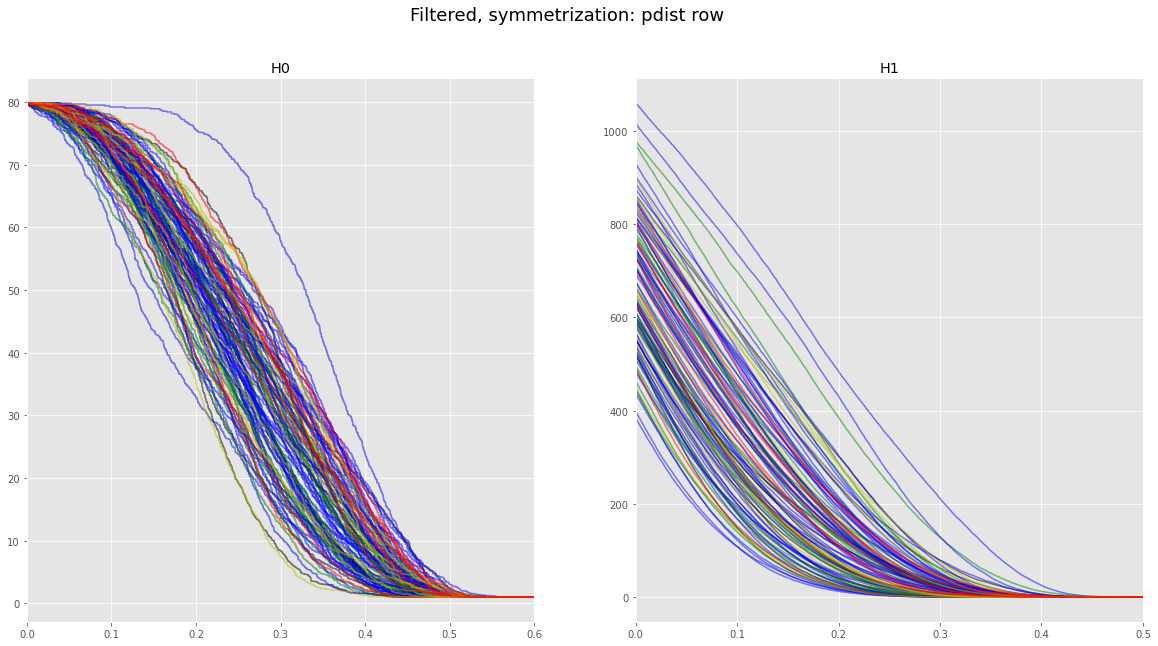

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Filtered, symmetrization: pdist row", fontsize=18)

for subject in range_of_subjects:
    hsr_subjects16[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects16[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0, 0.6)
ax[1].set_xlim(0, 0.5)